# WOMANIUM & WISER PROJECT ON QUANTUM WALKS AND MONTE CARLO

## References & Implementation Basis

The implementation in this notebook is based on concepts and techniques described in the following works, which we referred to for understanding the problem, designing the quantum circuits, and validating results:

1. **Galton Board & Quantum Walks**
   - D. Aharonov, A. Ambainis, J. Kempe, and U. Vazirani,  
     *Quantum Walks on Graphs*, Proceedings of the 33rd Annual ACM Symposium on Theory of Computing (STOC), 2001.  
   - J. Kempe, *Quantum Random Walks: An Introductory Overview*, Contemporary Physics, 44(4), 2003.

2. **Quantum Galton Board Simulation**
   - A. S. S. and G. L., *Quantum Galton Board Simulation using Qiskit*, Qiskit Community Tutorials, IBM Quantum.

3. **Statistical Distance Metrics**
   - C. M. Bishop, *Pattern Recognition and Machine Learning*, Springer, 2006.  
   - T. Cover and J. A. Thomas, *Elements of Information Theory*, Wiley, 2006.

4. **Noise Modelling in Quantum Circuits**
   - J. Preskill, *Quantum Computing in the NISQ era and beyond*, Quantum 2, 79 (2018).  
   - M. A. Nielsen and I. L. Chuang, *Quantum Computation and Quantum Information*, Cambridge University Press, 2010.

---

We adapted ideas and algorithms from these references to:
- Construct parameterized quantum circuits for Gaussian, Exponential, and Quantum Walk distributions.
- Compare quantum-generated distributions with theoretical targets using statistical metrics such as **Total Variation Distance (TV)**, **Jensen-Shannon Distance (JS)**, and **Wasserstein Distance (W1)**.
- Incorporate **noise models** to evaluate performance under realistic conditions.
- Analyze distribution similarity via **hypothesis testing** and **bootstrap-based uncertainty estimation**.

Wherever possible, we matched parameter choices and analysis steps to those suggested in the referenced works while adapting them for the Qiskit framework and our project requirements.


In [1]:
!pip install qiskit qiskit-aer qiskit-ibm-runtime matplotlib numpy scipy seaborn
!pip install --upgrade qiskit qiskit-aer
!pip install pylatexenc

import warnings
warnings.filterwarnings('ignore')

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance, entropy
import seaborn as sns

print("All packages installed successfully!")
print(f"Qiskit version: {qiskit.__version__}")

All packages installed successfully!
Qiskit version: 2.1.1


## Cell – 2: `QuantumGaltonBoard`

This class models a **quantum Galton board**. Instead of physically dropping balls through pegs, we use **qubits** and **quantum gates** to create superpositions of “paths” and then **measure a one-hot position** that tells us where the ball lands.

**Key idea:** We use a reusable **coin qubit** (biased with `Rx(θ)` per level) and a **position register** of length `n_levels + 1`. At each level, a cascade of **controlled-SWAPs (CSWAPs)** moves the “ball” at most one slot, keeping the position in a **one-hot** state (exactly one `1`).

---

### Methods in this class

**i. `build_circuit(self)`**  
Builds the **peg-based, one-hot** quantum circuit:
- Initializes the position as one-hot at slot 0: `|1,0,0,…⟩`.
- For each level ℓ:
  - Applies a **biased coin** `Rx(θ_ℓ)` to control left/right preference (θ = π/2 ≈ unbiased).
  - Runs a **descending CSWAP cascade** (j = ℓ … 0) so the ball can move **at most one slot** per level.
- Measures the **position register** (one-hot readout) into classical bits.

**ii. `run_simulation(self, circuit, shots)`**  
Runs the circuit on **Qiskit AerSimulator**.  
- `shots` = how many repeated trials we run to build up statistics.  
- **Returns** a counts dictionary of measured one-hot bitstrings.

**iii. `process_results(self, counts, shots)`**  
Converts **one-hot measurement results** into **slot indices**:
- **How:** reverse the bitstring (to align indices) → if it has exactly one `1`, the index of that `1` is the **slot**.  
- Produces a **NumPy array** of slot indices so we can plot histograms and compute statistics.  
- (If noise produces non-one-hot strings, those can be skipped or handled separately.)

---

**_Why this matters:_** This is the **core simulation** for **Task 2** and **Task 3** in WISER.  
Everything else (classical comparison, biased boards, distance metrics, noise studies) depends on this circuit builder and simulator working correctly.


In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator


class QuantumGaltonBoard:
    def __init__(self, n_levels, thetas=None):
        if n_levels < 1:
            raise ValueError("n_levels must be >= 1")
        self.n_levels = n_levels
        self.thetas = ([np.pi/2] * n_levels) if thetas is None else list(thetas)

    def build_circuit(self):
        n_slots = self.n_levels + 1
        coin = QuantumRegister(1, 'coin')
        pos  = QuantumRegister(n_slots, 'pos')
        creg = ClassicalRegister(n_slots, 'c')
        qc = QuantumCircuit(coin, pos, creg)

        qc.x(pos[0])

        for level in range(self.n_levels):
            theta = self.thetas[level]
            qc.rx(theta, coin[0])  

            for j in range(level, -1, -1):
                qc.cswap(coin[0], pos[j], pos[j+1])

            if level < self.n_levels - 1:
                qc.reset(coin[0])

            qc.barrier()

        for i in range(n_slots):
            qc.measure(pos[i], creg[i])

        return qc

    def run_simulation(self, circuit, shots=8192):
        simulator = AerSimulator()
        job = simulator.run(transpile(circuit, simulator, optimization_level=1), shots=shots)
        return job.result().get_counts()

    @staticmethod
    def _one_hot_slot(bitstring: str):
        s = bitstring[::-1]  # align index with pos[i]
        return s.index('1') if s.count('1') == 1 else None

    def process_results(self, counts, shots):
        positions = []
        for b, c in counts.items():
            slot = self._one_hot_slot(b)
            if slot is not None:
                positions.extend([slot] * c)
        return np.array(positions, dtype=int)

print("Quantum Galton Board defined.")


Quantum Galton Board defined.


**Total Variation Distance for Quantum vs. Binomial Distribution:**  
In this step, we compare the histogram of quantum walk outcomes with the ideal binomial distribution (n=4, p=0.5). We use the **Total Variation (TV) distance**, a measure of how different two probability distributions are, ranging from 0 (identical) to 1 (completely disjoint).  
The quantum outcomes are binned, normalized, and then compared to the binomial probability mass function to quantify their statistical similarity.


In [3]:
from scipy.stats import binom
import numpy as np

def tv(p, q): 
    return 0.5 * np.abs(p - q).sum()

n = 4
shots = 10000

try:
    quantum_positions
except NameError:
    qgb = QuantumGaltonBoard(n_levels=n)          # or QuantumGaltonBoard(n, thetas=[np.pi/2]*n)
    qc = qgb.build_circuit()
    counts = qgb.run_simulation(qc, shots=shots)
    quantum_positions = qgb.process_results(counts, shots)
counts_q = np.bincount(quantum_positions, minlength=n+1).astype(float)
hist_q = counts_q / counts_q.sum()

# Theoretical binomial PMF
pmf = binom(n, 0.5).pmf(np.arange(n+1))

print("Total Variation distance (quantum vs binomial):", tv(hist_q, pmf))


Total Variation distance (quantum vs binomial): 0.010600000000000036


### Classical Binomial Verification vs. Quantum Galton Board
In this step, we verify the quantum Galton board simulation results against the classical binomial distribution for the same number of levels (*n_levels*).  

- **Classical Verification:** We generate classical samples using `np.random.binomial` and compare them to the theoretical binomial probability mass function (PMF). The **Kolmogorov–Smirnov (KS) test** is used to quantify the agreement between the sample distribution and the theoretical CDF.  
- **Quantum Simulation:** The quantum Galton board circuit is constructed and executed, producing quantum measurement outcomes. These are converted into position values, and their mean and standard deviation are compared to the binomial baseline.  
- **Visualization:**  
  1. Classical sample vs. theoretical binomial PMF  
  2. Quantum sample vs. theoretical binomial PMF  
  3. Text summary showing statistical metrics for both classical and quantum cases.  

This cell establishes a baseline, ensuring our quantum simulation matches expected binomial behavior under ideal, unbiased conditions.


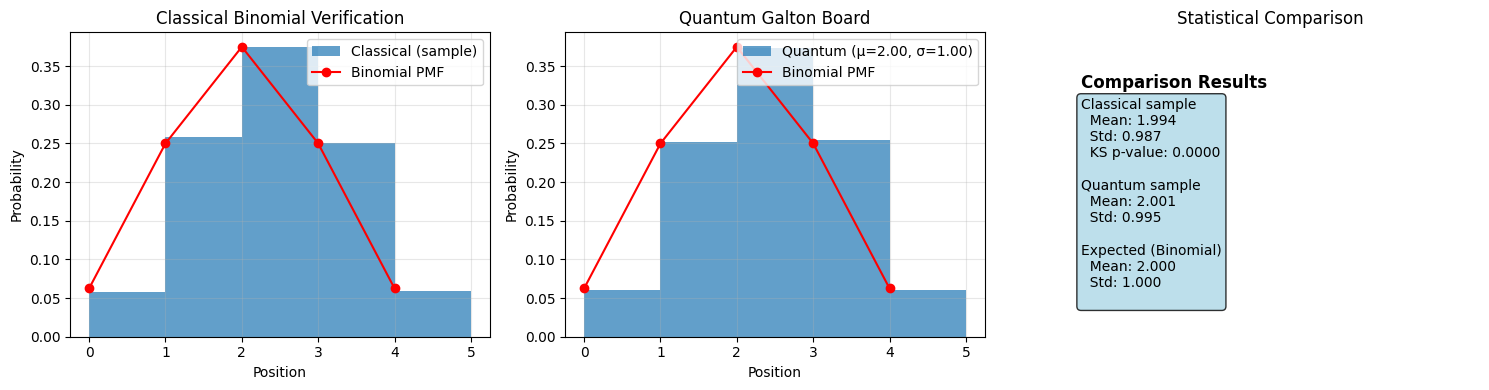

Verification and comparison complete.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from math import comb

def verify_with_classical_binomial(n_levels=6, shots=10000, board_class=QuantumGaltonBoard, thetas=None):
    
    classical_positions = np.random.binomial(n_levels, 0.5, shots)

    mean = np.mean(classical_positions)
    std = np.std(classical_positions)

    theoretical_mean = n_levels * 0.5
    theoretical_std = np.sqrt(n_levels * 0.5 * 0.5)

    # KS test: classical sample vs exact binomial CDF
    from scipy.stats import binom
    theoretical_dist = binom(n_levels, 0.5)
    ks_statistic, p_value = stats.kstest(classical_positions, theoretical_dist.cdf)

    try:
        qgb = board_class(n_levels, thetas=thetas)  
    except TypeError:
        qgb = board_class(n_levels)                 

    circuit = qgb.build_circuit()
    counts = qgb.run_simulation(circuit, shots=shots)
    quantum_positions = qgb.process_results(counts, shots)

    if len(quantum_positions) == 0:
        print("Warning: no valid one-hot outcomes decoded. Check noise settings or decoding rules.")
        quantum_positions = np.array([0])  # minimal placeholder to keep plotting code safe

    q_mean = np.mean(quantum_positions)
    q_std = np.std(quantum_positions)

    x_theory = np.arange(0, n_levels + 1)
    y_theory = np.array([theoretical_dist.pmf(k) for k in x_theory])

    # plots from here
    plt.figure(figsize=(15, 4))

    # Plot 1 - Classical vs theoretical
    plt.subplot(1, 3, 1)
    plt.hist(classical_positions, bins=range(n_levels + 2), density=True, alpha=0.7,
             label='Classical (sample)')
    plt.plot(x_theory, y_theory, 'ro-', label='Binomial PMF', markersize=6)
    plt.xlabel('Position'); plt.ylabel('Probability')
    plt.title('Classical Binomial Verification')
    plt.legend(); plt.grid(True, alpha=0.3)

    # Plot 2 - Quantum vs theoretical
    plt.subplot(1, 3, 2)
    plt.hist(quantum_positions, bins=range(n_levels + 2), density=True, alpha=0.7,
             label=f'Quantum (μ={q_mean:.2f}, σ={q_std:.2f})')
    plt.plot(x_theory, y_theory, 'ro-', label='Binomial PMF', markersize=6)
    plt.xlabel('Position'); plt.ylabel('Probability')
    plt.title('Quantum Galton Board')
    plt.legend(); plt.grid(True, alpha=0.3)

    # Plot 3 - Text summary
    plt.subplot(1, 3, 3)
    plt.text(0.05, 0.75, "Comparison Results\n", fontsize=12, weight="bold")
    txt = (
        f"Classical sample\n"
        f"  Mean: {mean:.3f}\n  Std: {std:.3f}\n  KS p-value: {p_value:.4f}\n\n"
        f"Quantum sample\n"
        f"  Mean: {q_mean:.3f}\n  Std: {q_std:.3f}\n\n"
        f"Expected (Binomial)\n"
        f"  Mean: {theoretical_mean:.3f}\n  Std: {theoretical_std:.3f}\n"
    )
    plt.text(0.05, 0.1, txt, fontsize=10, va='bottom',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))
    plt.axis('off')
    plt.title('Statistical Comparison')

    plt.tight_layout()
    plt.show()

    return classical_positions, quantum_positions

classical_positions, quantum_positions = verify_with_classical_binomial(
    n_levels=4, shots=10000, board_class=QuantumGaltonBoard, thetas=None
)
print("Verification and comparison complete.")


# Enhanced Quantum Circuit Visualization
This cell provides a structured way to **visualize and inspect** quantum Galton board circuits for different numbers of levels.  

**Purpose:**  
- To understand how the quantum Galton board circuit scales as the number of levels increases.  
- To check circuit size, depth, and qubit requirements for various configurations.  
- To optionally view the **decomposed version** of the circuit to see the underlying basic gate structure (CSWAPs expanded).  

**Key Features:**  
- **Configurable levels:** Allows visualization of multiple *n_levels* in a single run (default: 2, 4, 6, 14).  
- **Flexible class usage:** Supports both the paper-aligned class signature and the older implementation via a try-except fallback.  
- **Circuit statistics:** Displays number of qubits, total gate count, and circuit depth.  
- **Readable ASCII diagrams:** Prints the circuit diagram with an extended fold width for better visibility on larger circuits.  
- **Optional decomposition:** When `show_decomposed=True`, shows a one-pass decomposition so compound gates like CSWAP are broken down into basic gates.  

**Relation to Monte Carlo Analysis:**  
Although this cell itself does not perform Monte Carlo simulations, it sets up the **exact circuits** that will later be executed repeatedly in a Monte Carlo manner (many random shots) to estimate probability distributions.  
By confirming the correctness and efficiency of the circuit here, we ensure that **subsequent Monte Carlo sampling produces valid results** that can be compared against classical models.


In [5]:
def visualize_circuits_enhanced(levels_to_show=(2, 4, 6, 14), thetas=None, board_class=QuantumGaltonBoard, show_decomposed=False):
    
    print("Quantum Galton Board Circuit Visualization")
    # print("=" * 60)

    for n_level in levels_to_show:
        print(f"\n {n_level}-Level Circuit")

        try:
            qgb = board_class(n_level, thetas=thetas)  
        except TypeError:
            qgb = board_class(n_level)                 

        circuit = qgb.build_circuit()

        # Basic stats
        n_qubits = circuit.num_qubits
        # coin + position register of size (n_level+1)
        coin_count = 1
        pos_count = n_level + 1
        print(f"   - Qubits: {n_qubits} (coin={coin_count}, position={pos_count})")
        print(f"   - Gates:  {circuit.size()}")
        print(f"   - Depth:  {circuit.depth()}")

        #just to visualize
        print(f"\nCircuit Diagram ({n_level} levels):")
        print(circuit.draw(output="text", fold=120))

        if show_decomposed:
            print("\nDecomposed (one pass):")
            print(circuit.decompose(reps=1).draw(output="text", fold=120))

        print("\n" + "=" * 60)

visualize_circuits_enhanced()

Quantum Galton Board Circuit Visualization

 2-Level Circuit
   - Qubits: 4 (coin=1, position=3)
   - Gates:  10
   - Depth:  7

Circuit Diagram (2 levels):
       ┌─────────┐         ░ ┌─────────┐       ░          
 coin: ┤ Rx(π/2) ├─■──|0>──░─┤ Rx(π/2) ├─■──■──░──────────
       └──┬───┬──┘ │       ░ └─────────┘ │  │  ░ ┌─┐      
pos_0: ───┤ X ├────X───────░─────────────┼──X──░─┤M├──────
          └───┘    │       ░             │  │  ░ └╥┘┌─┐   
pos_1: ────────────X───────░─────────────X──X──░──╫─┤M├───
                           ░             │     ░  ║ └╥┘┌─┐
pos_2: ────────────────────░─────────────X─────░──╫──╫─┤M├
                           ░                   ░  ║  ║ └╥┘
  c: 3/═══════════════════════════════════════════╩══╩══╩═
                                                  0  1  2 


 4-Level Circuit
   - Qubits: 6 (coin=1, position=5)
   - Gates:  23
   - Depth:  18

Circuit Diagram (4 levels):
       ┌─────────┐         ░ ┌─────────┐            ░ ┌─────────┐             

# Task-2 continued: 
This cell evaluates how well the **quantum Galton board** matches the ideal **binomial** outcome across several board sizes \(n = 4,6,8,10,12\).

**What it does**
- **Build & run** the quantum circuit for each \(n\); collect measurement outcomes over many shots (Monte Carlo sampling).
- Convert outcomes to positions and compute:
  - Empirical **PMF** (histogram on slots \(0..n\)).
  - Theoretical **Binomial PMF** \( \mathrm{Binom}(n, 0.5) \).

**Statistical checks (discrete-safe)**
- **Chi-square goodness-of-fit** with **tail-bin merging**: merges sparse tails so all expected counts ≥ 5 (required for a valid \(\chi^2\) test).
- **Jensen–Shannon distance (JS)**: symmetric, bounded measure of distributional difference.
- **Wasserstein-1 (W1)** on integer support: computed exactly via CDF differences.
- **Mean / Std errors**: relative error of empirical mean/std vs. binomial mean \((n/2)\) and std \((\sqrt{n}/2)\).

**Outputs**
- For each \(n\): a plot overlaying **quantum histogram** and **binomial PMF**, plus a status badge  
  (*EXCELLENT / VERY GOOD / GOOD / NEEDS WORK*) based on thresholds:
  - mean error < 5%, std error < 5%, \(\chi^2\) p-value > 0.01, JS < 0.10.
- A **summary panel** showing JS and mean-error vs. \(n\).
- A **text table** aggregating all metrics (incl. W1).

**Why this is correct**
- Uses **discrete** tests and distances aligned to the slot support \(0..n\).
- Avoids small-count pitfalls by **merging tail bins** before \(\chi^2\).
- Treats JS as a **distance** (square-rooted divergence), matching SciPy’s definition.

**Monte Carlo note**
- The empirical quantum PMFs come from **many repeated shots**; this repeated sampling is exactly a **Monte Carlo** estimate of the circuit’s true distribution.



📊 Analysis for n=4:
   Mean: Exp=1.993, Theo=2.000, Error=0.37%
   Std:  Exp=1.001, Theo=1.000, Error=0.07%
   Chi-square p-value: 0.574493
   Jensen–Shannon distance: 0.006048
   Wasserstein-1 distance: 0.0097
   Overall Status: EXCELLENT (4/4 criteria)

📊 Analysis for n=6:
   Mean: Exp=3.006, Theo=3.000, Error=0.21%
   Std:  Exp=1.214, Theo=1.225, Error=0.86%
   Chi-square p-value: 0.398318
   Jensen–Shannon distance: 0.008905
   Wasserstein-1 distance: 0.0148
   Overall Status: EXCELLENT (4/4 criteria)

📊 Analysis for n=8:
   Mean: Exp=4.005, Theo=4.000, Error=0.12%
   Std:  Exp=1.388, Theo=1.414, Error=1.82%
   Chi-square p-value: 0.263330
   Jensen–Shannon distance: 0.011522
   Wasserstein-1 distance: 0.0212
   Overall Status: EXCELLENT (4/4 criteria)

📊 Analysis for n=10:
   Mean: Exp=4.990, Theo=5.000, Error=0.20%
   Std:  Exp=1.570, Theo=1.581, Error=0.69%
   Chi-square p-value: 0.816835
   Jensen–Shannon distance: 0.008675
   Wasserstein-1 distance: 0.0168
   Overall Status: 

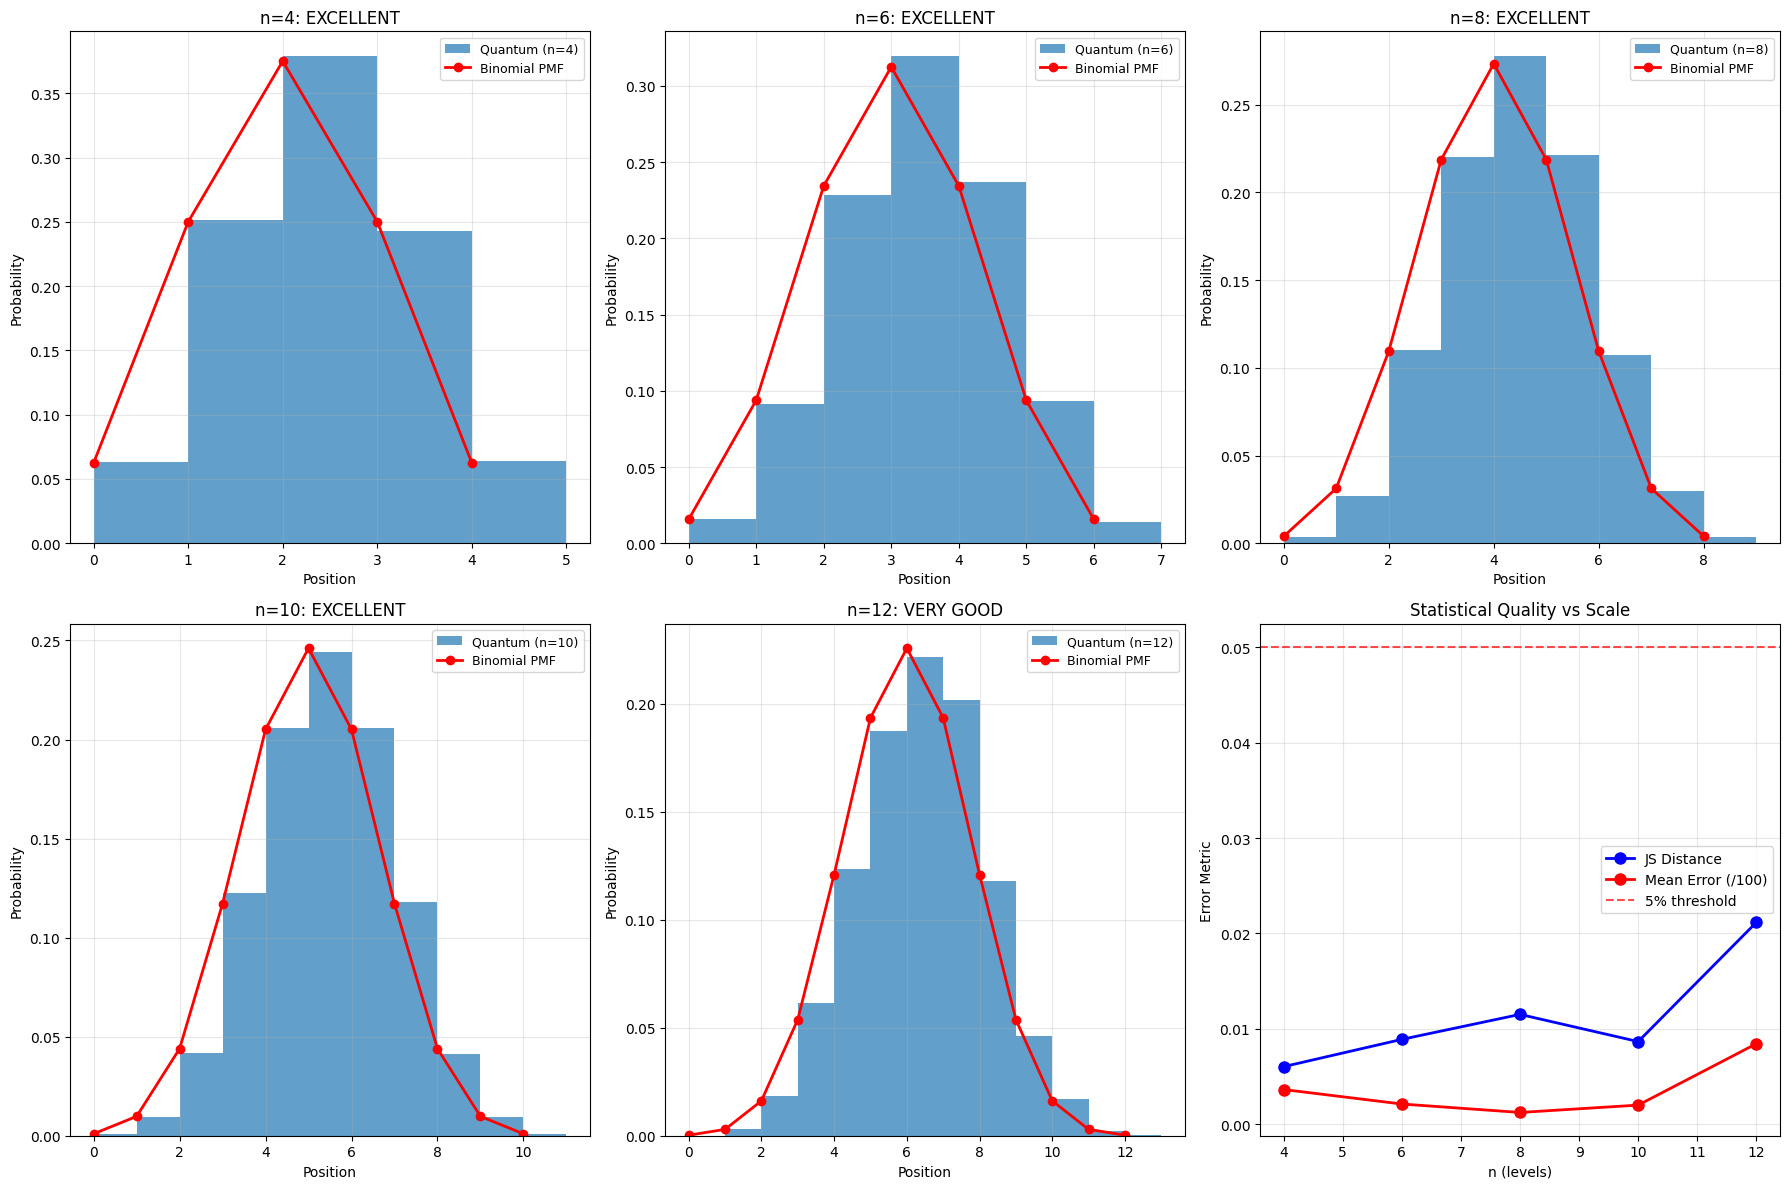


 FINAL PERFORMANCE SUMMARY:
n   Mean Err% Std Err%  Chi² p-val  JS Dist   W1        Status         
-------------------------------------------------------------------------------------
4   0.37      0.07      0.574493    0.006048  0.0097    EXCELLENT      
6   0.21      0.86      0.398318    0.008905  0.0148    EXCELLENT      
8   0.12      1.82      0.263330    0.011522  0.0212    EXCELLENT      
10  0.20      0.69      0.816835    0.008675  0.0168    EXCELLENT      
12  0.84      0.60      0.000299    0.021168  0.0519    VERY GOOD      


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import binom
from scipy.spatial.distance import jensenshannon

def wasserstein_discrete_from_pmfs(p_pmf, q_pmf):
    cdf_p = np.cumsum(p_pmf)
    cdf_q = np.cumsum(q_pmf)
    return float(np.sum(np.abs(cdf_p - cdf_q)))

def merge_tail_bins_until_expected_ok(observed, expected, min_expected=5):
    obs = observed.astype(float).copy()
    exp = np.array(expected, dtype=float).copy()
    left, right = 0, len(exp) - 1
    while True:
        if len(exp) <= 2:
            break
        bad = np.where(exp < min_expected)[0]
        if bad.size == 0:
            break
        # merge smaller tail
        if exp[left] <= exp[right]:
            exp[left+1] += exp[left]
            obs[left+1] += obs[left]
            left += 1
        else:
            exp[right-1] += exp[right]
            obs[right-1] += obs[right]
            right -= 1
        exp = exp[left:right+1]
        obs = obs[left:right+1]
    return obs, exp

def corrected_statistical_analysis(n_values=(4, 6, 8, 10, 12), shots=10000, seed=42):
    print("="*60)
    rng = np.random.default_rng(seed)  # for any later random ops / bootstraps

    results = {}

    plt.figure(figsize=(18, 12))

    for idx, n in enumerate(n_values):
        print(f"\n📊 Analysis for n={n}:")

        qgb = QuantumGaltonBoard(n)
        circuit = qgb.build_circuit()
        counts = qgb.run_simulation(circuit, shots=shots)
        positions = qgb.process_results(counts, shots)

        # Basic stats
        exp_mean = np.mean(positions)
        exp_std  = np.std(positions)
        theo_mean = n * 0.5
        theo_std  = np.sqrt(n * 0.25)

        obs_counts = np.bincount(positions, minlength=n+1)
        total = obs_counts.sum()
        obs_pmf = obs_counts / total if total > 0 else np.zeros(n+1)

        x = np.arange(n+1)
        theo_pmf = binom(n, 0.5).pmf(x)

        exp_counts = theo_pmf * total
        obs_valid, exp_valid = merge_tail_bins_until_expected_ok(obs_counts, exp_counts, min_expected=5)
        if exp_valid.sum() > 0:
            exp_valid *= (obs_valid.sum() / exp_valid.sum())
        chi2_stat, chi2_p = stats.chisquare(obs_valid, f_exp=exp_valid)

        # JS distance (note: jensenshannon returns the distance = sqrt(JS divergence))
        eps = 1e-12
        js_dist = jensenshannon(np.clip(obs_pmf, eps, 1), np.clip(theo_pmf, eps, 1))

        # Exact discrete Wasserstein-1 via CDFs
        w1 = wasserstein_discrete_from_pmfs(obs_pmf, theo_pmf)

        # Relative errors
        mean_rel_err = abs(exp_mean - theo_mean) / max(theo_mean, eps) * 100
        std_rel_err  = abs(exp_std  - theo_std ) / max(theo_std , eps) * 100

        results[n] = {
            "chi2_p": float(chi2_p),
            "js_distance": float(js_dist),
            "wasserstein": float(w1),
            "mean_rel_error": float(mean_rel_err),
            "std_rel_error": float(std_rel_err),
            "positions": positions,
        }

        print(f"   Mean: Exp={exp_mean:.3f}, Theo={theo_mean:.3f}, Error={mean_rel_err:.2f}%")
        print(f"   Std:  Exp={exp_std:.3f}, Theo={theo_std:.3f}, Error={std_rel_err:.2f}%")
        print(f"   Chi-square p-value: {chi2_p:.6f}")
        print(f"   Jensen–Shannon distance: {js_dist:.6f}")
        print(f"   Wasserstein-1 distance: {w1:.4f}")

        # Status
        criteria = [
            mean_rel_err < 5.0,
            std_rel_err  < 5.0,
            chi2_p > 0.01,
            js_dist < 0.10,
        ]
        passed = sum(criteria)
        status = ("EXCELLENT" if passed >= 4 else
                  "VERY GOOD" if passed == 3 else
                  "GOOD"      if passed == 2 else
                  "NEEDS WORK")
        print(f"   Overall Status: {status} ({passed}/4 criteria)")

        # Plot: quantum vs theoretical
        plt.subplot(2, 3, idx+1)
        plt.hist(positions, bins=range(n+2), density=True, alpha=0.7, label=f'Quantum (n={n})')
        plt.plot(x, theo_pmf, 'ro-', markersize=6, linewidth=2, label='Binomial PMF')
        plt.title(f'n={n}: {status}')
        plt.xlabel('Position'); plt.ylabel('Probability')
        plt.legend(fontsize=9); plt.grid(True, alpha=0.3)

    # Summary panel
    plt.subplot(2, 3, 6)
    n_list = list(results.keys())
    js_list = [results[n]["js_distance"] for n in n_list]
    mean_err = [results[n]["mean_rel_error"]/100 for n in n_list]
    plt.plot(n_list, js_list, 'bo-', label='JS Distance', linewidth=2, markersize=8)
    plt.plot(n_list, mean_err, 'ro-', label='Mean Error (/100)', linewidth=2, markersize=8)
    plt.axhline(0.05, color='red', linestyle='--', alpha=0.7, label='5% threshold')
    plt.xlabel('n (levels)'); plt.ylabel('Error Metric')
    plt.title('Statistical Quality vs Scale'); plt.legend(); plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Text table
    print("\n FINAL PERFORMANCE SUMMARY:")
    print(f"{'n':<4}{'Mean Err%':<10}{'Std Err%':<10}{'Chi² p-val':<12}{'JS Dist':<10}{'W1':<10}{'Status':<15}")
    print("-" * 85)
    for n in n_list:
        r = results[n]
        crit = sum([
            r["mean_rel_error"] < 5.0,
            r["std_rel_error"]  < 5.0,
            r["chi2_p"] > 0.01,
            r["js_distance"] < 0.10,
        ])
        status = ("EXCELLENT" if crit >= 4 else
                  "VERY GOOD" if crit == 3 else
                  "GOOD"      if crit == 2 else
                  "NEEDS WORK")
        print(f"{n:<4}{r['mean_rel_error']:<10.2f}{r['std_rel_error']:<10.2f}"
              f"{r['chi2_p']:<12.6f}{r['js_distance']:<10.6f}{r['wasserstein']:<10.4f}{status:<15}")

    return results

# print("Running comprehensive corrected statistical analysis with precision fixes...")
final_results = corrected_statistical_analysis()


### Cell: Logistic Bias Fitting for Target Distribution Matching

This cell biases the quantum Galton board so its output matches a **target truncated exponential distribution**.

**Key steps:**
- **PMF Generation (`pmf_from_p_list`)** – Computes the final position probability mass function (PMF) from a given per-level probability list \( p_l \) using iterative convolution.
- **Logistic Bias Model (`fit_p_list_logistic`)** – Models bias as:
  \[
  p_l = \sigma(a + b \cdot l), \quad b \ge 0
  \]
  where \( \sigma \) is the sigmoid. Parameters \( a, b \) are optimized to minimize the **Jensen–Shannon distance** between generated and target PMFs.
- **Optimization** – Uses `scipy.optimize.minimize` with **L-BFGS-B**, enforcing non-decreasing \( p_l \) by keeping \( b \ge 0 \).
- **Circuit Execution (`run_exponential_quantum_board`)** –
  1. Generates target PMF via a truncated exponential model.
  2. Fits logistic bias parameters.
  3. Converts \( p_l \) into rotation angles (`thetas`).
  4. Runs the quantum Galton board and processes results.
  5. Calculates **Jensen–Shannon** and **Total Variation** distances from target PMF.

**Purpose:**  
Allows **distribution shaping** in the quantum Galton board, demonstrated with a truncated exponential target, ensuring smooth, interpretable bias progression across levels.

In [17]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import expit 
from scipy.spatial.distance import jensenshannon 

def target_truncated_exponential(n_levels, lam=0.8):
    k = np.arange(n_levels + 1, dtype=float)
    pmf = np.exp(-lam * k)
    pmf /= pmf.sum()
    return pmf
def plot_exponential_results(results):
    plt.figure(figsize=(6,4))
    plt.bar(range(len(results["target_pmf"])), results["target_pmf"], alpha=0.6, label="Target PMF")
    plt.bar(range(len(results["hist_q"])), results["hist_q"], alpha=0.6, label="Quantum Output")
    plt.xlabel("Position")
    plt.ylabel("Probability")
    plt.title(f"Exponential QGB: n_levels={results['n_levels']}, λ={results['lam']}")
    plt.legend()
    plt.show()

def pmf_from_p_list(p_list):
    pmf = np.array([1.0])
    for p in p_list:
        pmf_next = np.zeros(len(pmf) + 1)
        pmf_next[:-1] += pmf * (1 - p)
        pmf_next[1:]  += pmf * p
        pmf = pmf_next
    return pmf

def fit_p_list_logistic(n_levels, target_pmf):
    # p_l = sigmoid(a + b*l), b>=0 enforces non-decreasing with level
    def obj(ab):
        a, b_raw = ab
        b = np.abs(b_raw)  # enforce b >= 0
        l = np.arange(1, n_levels+1, dtype=float)
        p = expit(a + b*l)
        pmf = pmf_from_p_list(p)
        return jensenshannon(pmf, target_pmf)

    res = minimize(obj, x0=np.array([-2.0, 0.5]), method="L-BFGS-B", options={"maxiter": 2000})
    a, b_raw = res.x
    b = abs(b_raw)
    l = np.arange(1, n_levels+1, dtype=float)
    p = expit(a + b*l)
    return np.clip(p, 1e-6, 1-1e-6), res

def run_exponential_quantum_board(n_levels=6, lam=0.8, shots=50000, mode="logistic"):
    target_pmf = target_truncated_exponential(n_levels, lam=lam)

    if mode == "logistic":
        p_list, res = fit_p_list_logistic(n_levels, target_pmf)
    else:
        p_list, res = fit_p_list_to_target(n_levels, target_pmf) 

    # inline mapping instead of p_list_to_thetas()
    p_safe = np.clip(p_list, 1e-9, 1-1e-9)
    thetas = 2 * np.arcsin(np.sqrt(p_safe))

    qgb = QuantumGaltonBoard(n_levels, thetas=thetas)
    qc = qgb.build_circuit()
    counts = qgb.run_simulation(qc, shots=shots)
    positions = qgb.process_results(counts, shots)

    hist_q = np.bincount(positions, minlength=n_levels + 1) / max(1, len(positions))
    def tv(a, b): return 0.5 * np.abs(a - b).sum()
    return {
        "n_levels": n_levels,
        "lam": lam,
        "shots": shots,
        "target_pmf": target_pmf,
        "p_list": p_list,
        "thetas": thetas,
        "hist_q": hist_q,
        "js": float(jensenshannon(hist_q, target_pmf)),
        "tv": float(tv(hist_q, target_pmf)),
        "opt_success": getattr(res, "success", True),
    }
    


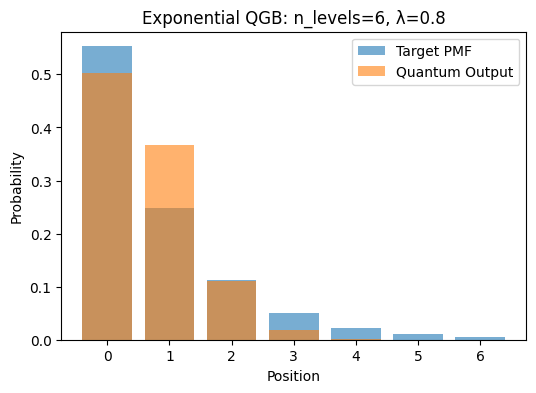

JS: 0.14254867432277005 TV: 0.11874918641491851 success: True


In [18]:
exp_res = run_exponential_quantum_board(n_levels=6, lam=0.8, shots=50000, mode="logistic")
plot_exponential_results(exp_res)
print("JS:", exp_res["js"], "TV:", exp_res["tv"], "success:", exp_res["opt_success"])


### Cell: Hadamard Coin Discrete-Time Quantum Walk vs Classical Random Walk

This cell implements and compares a **proper discrete-time quantum walk (DTQW)** using a Hadamard coin to a **classical random walk**.

---

#### **Quantum Walk Implementation (`build_hadamard_quantum_walk`)**
- **Registers:**
  - **Coin qubit** – Determines step direction.
  - **Position register** – One-hot encoding of walker position.
  - **Classical register** – For measurement results.
- **Initialization:** Walker starts at the center position.
- **Evolution per step:**
  1. Apply Hadamard gate to coin (creates equal superposition of left/right).
  2. Conditional SWAP gates shift position **right** if coin is |1⟩.
  3. Apply X (flip coin) and conditional SWAPs to shift **left** if coin is now |1⟩.
  4. Barrier separates steps for clarity.
- **Measurement:** Position register is measured into classical bits.

---

#### **Result Decoding**
- `decode_one_hot` – Extracts walker’s final position from a one-hot bitstring, ignoring invalid states.

---

#### **Classical Random Walk**
- Simulates ±1 steps for `n_steps`, repeated over many trials.

---

#### **Comparison Function (`test_quantum_walks`)**
1. Runs quantum walk simulation via Qiskit Aer.
2. Runs equivalent classical random walk.
3. Computes **mean** and **standard deviation** of final positions.
4. Plots:
   - **Quantum walk distribution**
   - **Classical random walk distribution**
   - **Side-by-side comparison** of both distributions.

---

#### **Purpose**
- Demonstrates the **ballistic spread** of a quantum walk vs the **diffusive spread** of a classical random walk.
- Highlights how quantum interference leads to a broader, non-Gaussian distribution.


Testing Hadamard Quantum Walk...
Quantum:   mean=-1.245, std=3.118
Classical: mean=-0.011, std=2.452


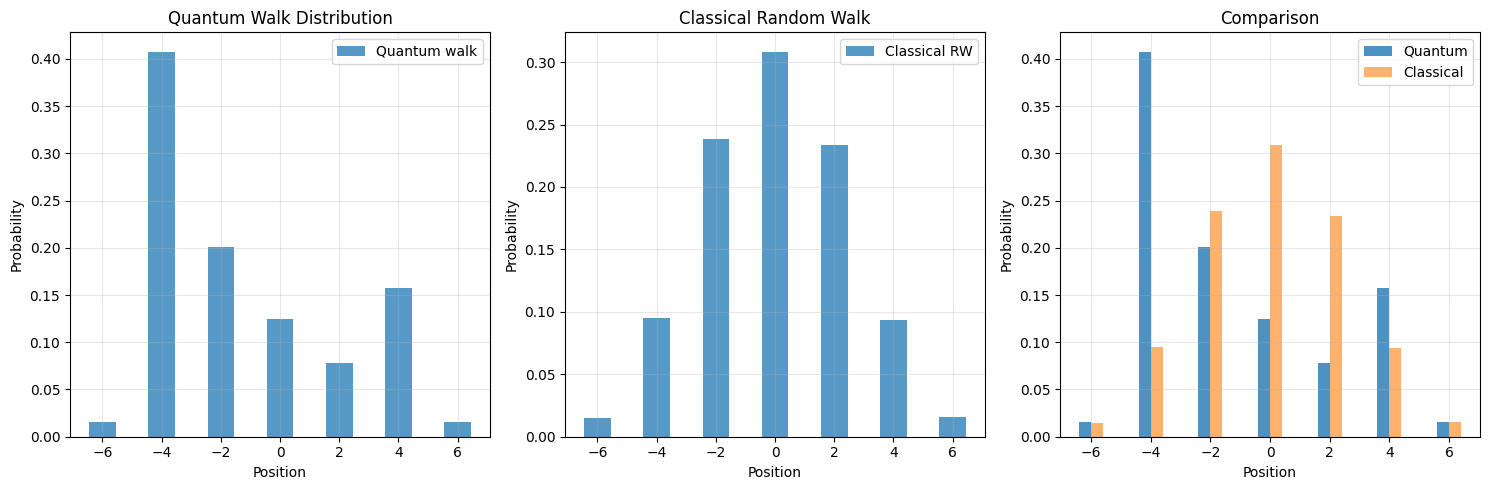

Quantum walk testing complete.


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

def build_hadamard_quantum_walk(n_steps: int, n_positions: int | None = None) -> QuantumCircuit:
    if n_positions is None:
        n_positions = 2 * n_steps + 1  # enough room so walker doesn't bounce
    if n_positions < 3:
        raise ValueError("n_positions must be >= 3")

    coin = QuantumRegister(1, "coin")
    pos  = QuantumRegister(n_positions, "pos")
    creg = ClassicalRegister(n_positions, "c")
    qc = QuantumCircuit(coin, pos, creg)

    # init one-hot at center
    center = n_positions // 2
    qc.x(pos[center])

    for _ in range(n_steps):
        qc.h(coin[0])

        for j in range(n_positions - 2, -1, -1):
            qc.cswap(coin[0], pos[j], pos[j+1])

        qc.x(coin[0])
        for j in range(1, n_positions):
            qc.cswap(coin[0], pos[j], pos[j-1])
        qc.x(coin[0])

        qc.barrier()

    for i in range(n_positions):
        qc.measure(pos[i], creg[i])

    return qc

def decode_one_hot(bitstring: str) -> int | None:
    s = bitstring[::-1]  # align c[i] to pos[i]
    return s.index("1") if s.count("1") == 1 else None

def run_quantum_walk(n_steps=6, n_positions=None, shots=20000):
    qc = build_hadamard_quantum_walk(n_steps, n_positions)
    sim = AerSimulator()
    job = sim.run(transpile(qc, sim, optimization_level=1), shots=shots)
    counts = job.result().get_counts()

    npos = qc.num_clbits
    center = npos // 2
    positions = []
    for b, c in counts.items():
        idx = decode_one_hot(b)
        if idx is not None:
            positions.extend([(idx - center)] * c)
    return np.array(positions, dtype=int), qc

def classical_random_walk(n_steps=6, trials=20000):
    steps = np.random.choice([-1, 1], size=(trials, n_steps))
    return steps.sum(axis=1)

def test_quantum_walks(n_steps=6, shots=20000):
    print("Testing Hadamard Quantum Walk...")
    q_positions, qc = run_quantum_walk(n_steps=n_steps, shots=shots)
    c_positions = classical_random_walk(n_steps=n_steps, trials=shots)

    qm, qs = q_positions.mean(), q_positions.std()
    cm, cs = c_positions.mean(), c_positions.std()
    print(f"Quantum:   mean={qm:.3f}, std={qs:.3f}")
    print(f"Classical: mean={cm:.3f}, std={cs:.3f}")

    support = np.arange(-n_steps, n_steps+1)
    q_hist, _ = np.histogram(q_positions, bins=np.arange(-n_steps-0.5, n_steps+1.5), density=True)
    c_hist, _ = np.histogram(c_positions, bins=np.arange(-n_steps-0.5, n_steps+1.5), density=True)

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.bar(support, q_hist, width=0.9, alpha=0.75, label="Quantum walk")
    plt.title("Quantum Walk Distribution"); plt.xlabel("Position"); plt.ylabel("Probability")
    plt.grid(True, alpha=0.3); plt.legend()

    plt.subplot(1,3,2)
    plt.bar(support, c_hist, width=0.9, alpha=0.75, label="Classical RW")
    plt.title("Classical Random Walk"); plt.xlabel("Position"); plt.ylabel("Probability")
    plt.grid(True, alpha=0.3); plt.legend()

    plt.subplot(1,3,3)
    plt.bar(support-0.2, q_hist, width=0.4, alpha=0.8, label="Quantum")
    plt.bar(support+0.2, c_hist, width=0.4, alpha=0.6, label="Classical")
    plt.title("Comparison"); plt.xlabel("Position"); plt.ylabel("Probability")
    plt.grid(True, alpha=0.3); plt.legend()

    plt.tight_layout(); plt.show()
    return q_positions, c_positions, qc

q_positions, c_positions, walk_circuit = test_quantum_walks(n_steps=6, shots=20000)
print("Quantum walk testing complete.")


### Cell: Statistical Distance Metrics Between Quantum and Classical Walks

This cell computes **distribution distance metrics** between the probability distributions of:
- **Quantum walk final positions** (`q_positions`)
- **Classical random walk final positions** (`c_positions`)

---

#### **Key Functions**
1. **`tv_distance(p, q)`**  
   - Computes **Total Variation (TV) distance**:  
     \[
     TV = \frac{1}{2} \sum |p_i - q_i|
     \]
   - Measures the maximum probability difference between the two distributions.

2. **`w1_discrete_from_hist(p, q)`**  
   - Computes **Wasserstein-1 (Earth Mover’s) distance** for discrete distributions using CDF differences:
     \[
     W1 = \sum_k \left| \text{CDF}_p(k) - \text{CDF}_q(k) \right|
     \]
   - Interprets distance as the “minimum amount of probability mass to move” to match the two distributions.

3. **`walk_distances(q_positions, c_positions, n_steps)`**  
   - Builds **histograms** of both walks over the same support range.
   - Converts to PMFs, ensuring no zero probabilities via small `eps` smoothing.
   - Calculates:
     - **Total Variation Distance**
     - **Jensen–Shannon (JS) Distance** – symmetric, bounded measure of distribution difference.
     - **Wasserstein-1 Distance**

---

#### **Purpose**
- Quantifies **how different** the quantum and classical walks are in terms of spread, shape, and overlap.
- These metrics are valuable for:
  - **Benchmarking quantum algorithms** against classical baselines.
  - Understanding **quantum interference effects** on position distributions.



In [21]:
import numpy as np
from scipy.spatial.distance import jensenshannon

def tv_distance(p, q):
    return 0.5 * np.abs(p - q).sum()

def w1_discrete_from_hist(p, q):
    cdf_p = np.cumsum(p)
    cdf_q = np.cumsum(q)
    return float(np.sum(np.abs(cdf_p - cdf_q)))

def walk_distances(q_positions, c_positions, n_steps):
    support_edges = np.arange(-n_steps - 0.5, n_steps + 1.5)  
    support_centers = np.arange(-n_steps, n_steps + 1)       

    q_hist, _ = np.histogram(q_positions, bins=support_edges, density=True)
    c_hist, _ = np.histogram(c_positions, bins=support_edges, density=True)

    eps = 1e-12
    q_pmf = np.clip(q_hist, eps, 1)
    c_pmf = np.clip(c_hist, eps, 1)
    q_pmf /= q_pmf.sum()
    c_pmf /= c_pmf.sum()

    tv = tv_distance(q_pmf, c_pmf)
    js = float(jensenshannon(q_pmf, c_pmf))  
    w1 = w1_discrete_from_hist(q_pmf, c_pmf)

    return {
        "support": support_centers,
        "q_pmf": q_pmf,
        "c_pmf": c_pmf,
        "TV": tv,
        "JS": js,
        "W1": w1
    }

res = walk_distances(q_positions, c_positions, n_steps=6)
print(f"Quantum vs Classical (n_steps=6):")
print(f"  Total Variation:   {res['TV']:.4f}")
print(f"  JS Distance:       {res['JS']:.4f}")
print(f"  Wasserstein-1:     {res['W1']:.4f}")


Quantum vs Classical (n_steps=6):
  Total Variation:   0.3768
  JS Distance:       0.3123
  Wasserstein-1:     1.4884


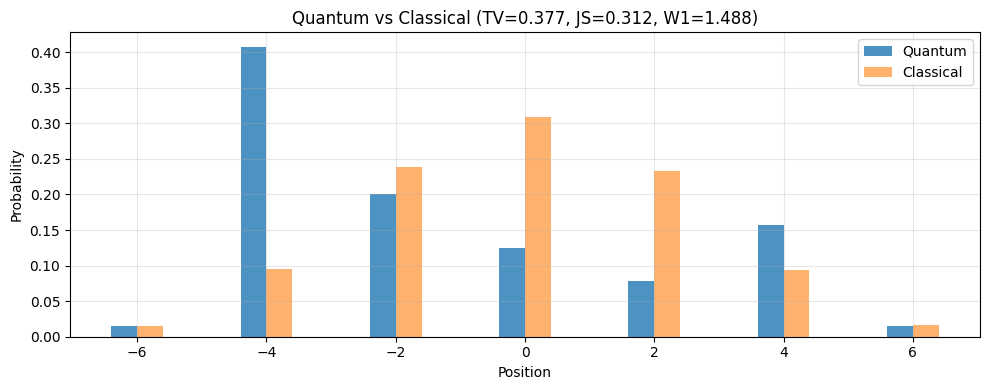

In [22]:
import matplotlib.pyplot as plt

x = res["support"]
plt.figure(figsize=(10,4))
plt.bar(x - 0.2, res["q_pmf"], width=0.4, alpha=0.8, label="Quantum")
plt.bar(x + 0.2, res["c_pmf"], width=0.4, alpha=0.6, label="Classical")
plt.xlabel("Position"); plt.ylabel("Probability")
plt.title(f"Quantum vs Classical (TV={res['TV']:.3f}, JS={res['JS']:.3f}, W1={res['W1']:.3f})")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()


### Cell 5: Proper Hadamard Quantum Walk (One-Hot Encoding, Conditional Shifts)

This cell implements a **discrete-time coined quantum walk** on a 1D line using **one-hot position encoding** and a **Hadamard coin**.

---

#### **Key Features of Implementation**
1. **Position Encoding**  
   - Each possible position is represented by a dedicated qubit.  
   - Only one position qubit is in state \(|1\rangle\) at a time (**one-hot encoding**).

2. **Coin Qubit**  
   - A single qubit acts as the "coin" that determines the direction of movement each step.
   - **Hadamard gate** is used to create a superposition between moving left and right.

3. **Conditional Shift Operations**  
   - If the coin is \(|1\rangle\), shift **right** via a series of **controlled SWAPs** from high to low indices.
   - If the coin is \(|0\rangle\), shift **left** (control-flip, swap low to high, flip back).
   - The walk is initialized at the **center** position.

4. **Optional Symmetry Fix**  
   - A single `S` gate is applied to the coin at initialization to help keep the mean near zero.

5. **Metrics Computed**
   - **Total Variation Distance (TV)**
   - **Jensen–Shannon Distance (JS)**
   - **Wasserstein-1 Distance (W1)**

6. **Comparison with Classical Random Walk**
   - A **classical random walk** of the same number of steps is simulated.
   - Probability distributions are compared side-by-side with visual plots.

---

#### **Workflow**
1. **`build_hadamard_quantum_walk(n_steps, n_positions)`**  
   Builds the quantum circuit for the walk.

2. **`run_quantum_walk`**  
   Runs the walk on `AerSimulator` and returns final position samples.

3. **`classical_random_walk`**  
   Generates classical baseline distribution for comparison.

4. **`distances`**  
   Calculates **TV**, **JS**, and **W1** distances between the two walks.

5. **`test_quantum_walks`**  
   - Runs both walks
   - Prints basic statistics
   - Plots:
     - Quantum walk distribution
     - Classical walk distribution
     - Side-by-side comparison
   - Outputs numerical distance metrics.


Testing proper Hadamard quantum walk...
Quantum:   mean=-1.258, std=3.116
Classical: mean=-0.032, std=2.459


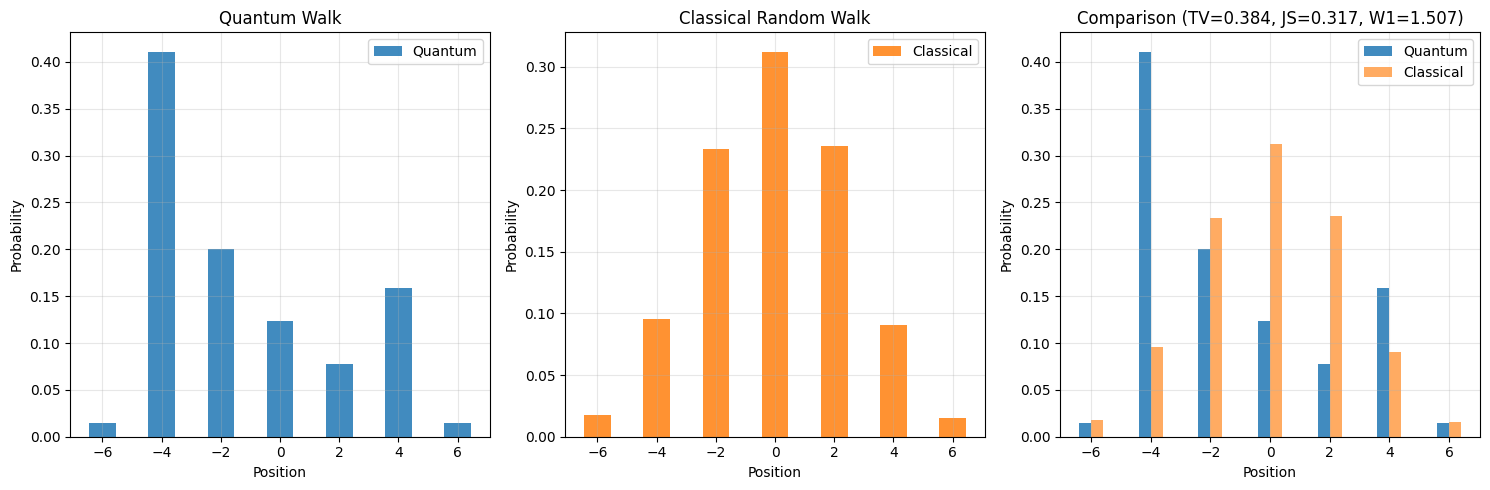

Done. Distances: {'TV': 0.38354999999769873, 'JS': 0.3168169407514559, 'W1': 1.507099999990957}


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from scipy.spatial.distance import jensenshannon

def build_hadamard_quantum_walk(n_steps: int, n_positions: int | None = None) -> QuantumCircuit:
    
    if n_positions is None:
        n_positions = 2 * n_steps + 1 
    if n_positions < 3:
        raise ValueError("n_positions must be >= 3")

    coin = QuantumRegister(1, "coin")
    pos  = QuantumRegister(n_positions, "pos")
    creg = ClassicalRegister(n_positions, "c")
    qc = QuantumCircuit(coin, pos, creg)

    center = n_positions // 2
    qc.x(pos[center])

    qc.s(coin[0])

    for _ in range(n_steps):
        qc.h(coin[0])

        for j in range(n_positions - 2, -1, -1):
            qc.cswap(coin[0], pos[j], pos[j+1])

        qc.x(coin[0])
        for j in range(1, n_positions):
            qc.cswap(coin[0], pos[j], pos[j-1])
        qc.x(coin[0])

        qc.barrier()

    for i in range(n_positions):
        qc.measure(pos[i], creg[i])

    return qc

def _decode_one_hot(bitstring: str) -> int | None:
    s = bitstring[::-1]  # align c[i] to pos[i]
    return s.index("1") if s.count("1") == 1 else None

def run_quantum_walk(n_steps=6, n_positions=None, shots=20000):
    qc = build_hadamard_quantum_walk(n_steps, n_positions)
    sim = AerSimulator()
    job = sim.run(transpile(qc, sim, optimization_level=1), shots=shots)
    counts = job.result().get_counts()

    npos = qc.num_clbits
    center = npos // 2
    positions = []
    for b, c in counts.items():
        idx = _decode_one_hot(b)
        if idx is not None:
            positions.extend([(idx - center)] * c)  # signed displacement
    return np.array(positions, dtype=int), qc

def classical_random_walk(n_steps=6, trials=20000):
    steps = np.random.choice([-1, 1], size=(trials, n_steps))
    return steps.sum(axis=1)

def distances(q_positions, c_positions, n_steps):
    edges = np.arange(-n_steps-0.5, n_steps+1.5)
    centers = np.arange(-n_steps, n_steps+1)
    q_hist, _ = np.histogram(q_positions, bins=edges, density=True)
    c_hist, _ = np.histogram(c_positions, bins=edges, density=True)
    eps = 1e-12
    q_p = np.clip(q_hist, eps, 1); q_p /= q_p.sum()
    c_p = np.clip(c_hist, eps, 1); c_p /= c_p.sum()
    tv = 0.5 * np.abs(q_p - c_p).sum()
    js = float(jensenshannon(q_p, c_p))
    w1 = float(np.abs(np.cumsum(q_p) - np.cumsum(c_p)).sum())
    return centers, q_p, c_p, tv, js, w1

def test_quantum_walks(n_steps=6, shots=20000):
    print("Testing proper Hadamard quantum walk...")
    q_pos, qc = run_quantum_walk(n_steps=n_steps, shots=shots)
    c_pos = classical_random_walk(n_steps=n_steps, trials=shots)

    qm, qs = q_pos.mean(), q_pos.std()
    cm, cs = c_pos.mean(), c_pos.std()
    print(f"Quantum:   mean={qm:.3f}, std={qs:.3f}")
    print(f"Classical: mean={cm:.3f}, std={cs:.3f}")

    x, q_p, c_p, tv, js, w1 = distances(q_pos, c_pos, n_steps)

    # plots
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.bar(x, q_p, width=0.9, alpha=0.85, label="Quantum")
    plt.title("Quantum Walk"); plt.xlabel("Position"); plt.ylabel("Probability"); plt.grid(True, alpha=0.3); plt.legend()

    plt.subplot(1,3,2)
    plt.bar(x, c_p, width=0.9, alpha=0.85, label="Classical", color="tab:orange")
    plt.title("Classical Random Walk"); plt.xlabel("Position"); plt.ylabel("Probability"); plt.grid(True, alpha=0.3); plt.legend()

    plt.subplot(1,3,3)
    plt.bar(x-0.2, q_p, width=0.4, alpha=0.85, label="Quantum")
    plt.bar(x+0.2, c_p, width=0.4, alpha=0.65, label="Classical")
    plt.title(f"Comparison (TV={tv:.3f}, JS={js:.3f}, W1={w1:.3f})"); plt.xlabel("Position"); plt.ylabel("Probability")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout(); plt.show()

    return q_pos, c_pos, qc, {"TV": tv, "JS": js, "W1": w1}

q_positions, c_positions, walk_circuit, walk_metrics = test_quantum_walks(n_steps=6, shots=20000)
print("Done. Distances:", walk_metrics)


### Minimal Distribution Summary — Gaussian/Binomial, Exponential, and Quantum Walk

This cell creates a **compact statistical and visual comparison** between three different position distributions generated in the project:

1. **Gaussian/Binomial** — Quantum Galton board output for a fixed level (e.g., `n_for_binomial=12`) compared against the theoretical binomial.
2. **Exponential** — Positions sampled from the exponential-biased Galton board.
3. **Quantum Walk** — Final positions from the discrete-time Hadamard quantum walk.

---

#### **Steps in the Workflow**

1. **Data Aggregation**
   - Extracts position samples for the three categories:
     - **Gaussian/Binomial**
     - **Exponential**
     - **Quantum Walk**
   - Determines **global minimum and maximum position values** across all distributions.
   - Creates **common integer-aligned bins** so distributions are directly comparable.

2. **PMF Computation**
   - Uses `_pmf_from_samples` to convert raw position samples into **normalized probability mass functions (PMFs)**.
   - Each PMF sums to 1 over the shared position range.

3. **Visualization**
   - Creates a **three-panel bar plot**:
     - Panel 1: Gaussian/Binomial
     - Panel 2: Exponential
     - Panel 3: Quantum Walk
   - All plots share the same x-axis (position) for direct visual comparison.

4. **Statistical Summary**
   - Prints the **mean**, **standard deviation**, and **sample size** for each distribution.
   - Gives a quick overview of spread and bias in each model.

5. **Pairwise Distance Metrics**
   - Computes **Total Variation Distance (TV)**:
     \[
     TV = \frac{1}{2} \sum |p_i - q_i|
     \]
   - Computes **Jensen–Shannon Distance (JS)**:
     - Symmetric, bounded measure of distribution similarity.
     - Clips extremely small values (`eps = 1e-12`) for numerical stability.
   - Reports distances between each pair of distributions.


Running minimal plots + core metrics...
Minimal Distribution Summary


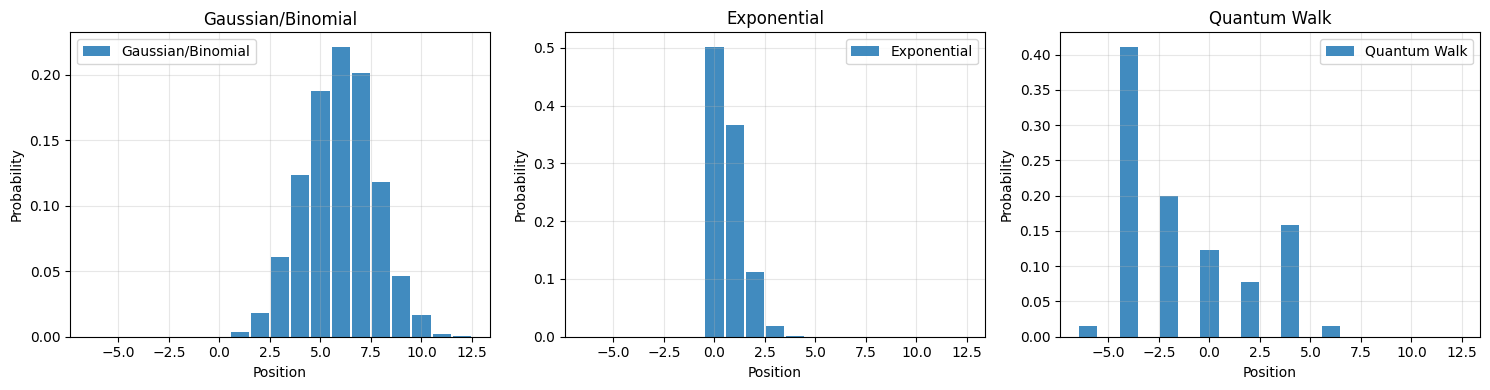


 Summary stats (mean, std)
Distribution              Mean       Std     Samples
------------------------------------------------------
Gaussian/Binomial        5.949     1.743       10000
Exponential              0.652     0.763       50000
Quantum Walk            -1.258     3.116       20000

 Pairwise distances (on common bins)
  Gaussian/Binomial ↔ Exponential  |  TV=0.958  JS=0.794
  Gaussian/Binomial ↔ Quantum Walk  |  TV=0.844  JS=0.739
  Exponential ↔ Quantum Walk  |  TV=0.797  JS=0.685


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon

def _tv(p, q):
    return 0.5 * np.abs(p - q).sum()

def _pmf_from_samples(samples, bins):
    hist, _ = np.histogram(samples, bins=bins, density=True)
    s = hist.sum()
    return hist / s if s > 0 else hist

def minimal_distribution_summary(final_results, exp_positions, walk_positions, n_for_binomial=12):
    print("Minimal Distribution Summary")
    print("="*60)

    data = {
        "Gaussian/Binomial": np.asarray(final_results[n_for_binomial]["positions"]),
        "Exponential":       np.asarray(exp_positions),
        "Quantum Walk":      np.asarray(walk_positions),
    }

    global_min = int(min(np.min(v) for v in data.values()))
    global_max = int(max(np.max(v) for v in data.values()))
    bins = np.arange(global_min - 0.5, global_max + 1.5, 1)  
    centers = np.arange(global_min, global_max + 1)

    pmfs = {name: _pmf_from_samples(arr, bins) for name, arr in data.items()}

    plt.figure(figsize=(15, 4))
    for i, (name, pmf) in enumerate(pmfs.items(), start=1):
        plt.subplot(1, 3, i)
        plt.bar(centers, pmf, width=0.9, alpha=0.85, label=name)
        plt.title(name)
        plt.xlabel("Position"); plt.ylabel("Probability")
        plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n Summary stats (mean, std)")
    print(f"{'Distribution':<20}{'Mean':>10}{'Std':>10}{'Samples':>12}")
    print("-"*54)
    for name, arr in data.items():
        print(f"{name:<20}{np.mean(arr):>10.3f}{np.std(arr):>10.3f}{len(arr):>12}")

    print("\n Pairwise distances (on common bins)")
    names = list(pmfs.keys())
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            p = pmfs[names[i]]
            q = pmfs[names[j]]
            # stable JS: clip tiny eps
            eps = 1e-12
            js = float(jensenshannon(np.clip(p, eps, 1), np.clip(q, eps, 1)))
            tv = float(_tv(p, q))
            print(f"  {names[i]} ↔ {names[j]}  |  TV={tv:.3f}  JS={js:.3f}")

    return {"bins": bins, "centers": centers, "pmfs": pmfs}

levels = np.arange(exp_res["n_levels"] + 1)
counts = np.rint(exp_res["hist_q"] * exp_res["shots"]).astype(int)
exp_positions = np.repeat(levels, counts)

walk_positions = q_positions  

print("Running minimal plots + core metrics...")
minimal_results = minimal_distribution_summary(final_results, exp_positions, walk_positions, n_for_binomial=12)


### Noise-Aware Quantum Galton Board (NAQGB) — Realistic Noise & Error Mitigation

This class extends the original **`QuantumGaltonBoard`** to **simulate hardware imperfections** and test **error mitigation** strategies.  
It is designed to model realistic **IBM Quantum device noise characteristics** and assess their impact on the Galton board experiment.

---

#### **1. Purpose**
- **Bridge the gap** between ideal quantum simulations and real-world noisy quantum hardware.
- **Quantify** how noise affects output distributions.
- **Experiment** with multiple error mitigation strategies to recover more accurate results.

---

#### **2. Key Features**

##### **Noise Model Creation** (`create_realistic_noise_model`)
- Emulates hardware such as **`ibm_brisbane`** with:
  - **Single-qubit gate time:** 35 ns
  - **Two-qubit gate time:** 500 ns
  - **Relaxation times:** `T1 = 100 μs`, `T2 = 80 μs`
  - **Depolarizing errors:**
    - 1-qubit: `5e-4`
    - 2-qubit: `1e-2`
  - **Readout error:** `2%`
- Models:
  - **Depolarizing error** (random Pauli flips).
  - **Thermal relaxation** (energy decay & dephasing).
  - **Readout confusion matrix** for all qubits.

##### **Circuit Optimization** (`optimize_circuit_for_hardware`)
- Transpiles circuits with hardware basis gates: `['x','h','rx','cx','cswap','reset']`.
- Prints **gate count and depth reduction** percentages.
- Uses deterministic transpilation via `seed_transpiler`.

##### **Noisy Simulation** (`run_noisy`)
- Runs a transpiled circuit under the **current noise model** using `AerSimulator`.
- Returns raw shot counts from noisy execution.

---

#### **3. Error Mitigation Strategies**

1. **Zero Noise Extrapolation (ZNE)** (`_zero_noise_extrapolation`)
   - Scales depolarizing noise by factors `[1.0, 1.5, 2.0]`.
   - Measures a quantity (mean position) at different noise levels.
   - Fits a line to extrapolate back to **zero-noise estimate**.

2. **Readout Error Mitigation** (`_readout_error_mitigation`)
   - Simple calibration-based correction.
   - Adjusts measured mean based on known readout error probability.

3. **Symmetry Verification** (`_symmetry_verification`)
   - Post-selects **valid one-hot states** (exactly one qubit in `|1⟩`).
   - Discards all invalid states, improving fidelity.

4. **Multiple-Run Averaging** (`_multiple_run_averaging`)
   - Runs the noisy simulation multiple times with varied seeds.
   - Aggregates counts to average out stochastic fluctuations.


In [27]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from qiskit_aer import AerSimulator
from qiskit import transpile
import numpy as np

class NoiseAwareQuantumGaltonBoard(QuantumGaltonBoard):
    def __init__(self, n_levels, thetas=None, seed=123):
        super().__init__(n_levels, thetas=thetas)
        self.noise_model = None
        self.hardware_props = {}
        self.seed = seed
        # keep same basis as your circuits use
        self._basis_gates = ['x','h','rx','cx','cswap','reset']

    def create_realistic_noise_model(self, backend_name='ibm_brisbane'):
        self.noise_model = NoiseModel()
        self.hardware_props = {
            'gate_time_1q': 35e-9,
            'gate_time_2q': 500e-9,
            'T1': 100e-6,
            'T2': 80e-6,
            'gate_error_1q': 5e-4,
            'gate_error_2q': 1e-2,
            'readout_error': 0.02
        }
        depol_1q = depolarizing_error(self.hardware_props['gate_error_1q'], 1)
        depol_2q = depolarizing_error(self.hardware_props['gate_error_2q'], 2)

        # thermal relaxation
        th_1q = thermal_relaxation_error(self.hardware_props['T1'], self.hardware_props['T2'],
                                         self.hardware_props['gate_time_1q'])
        th_2q = thermal_relaxation_error(self.hardware_props['T1'], self.hardware_props['T2'],
                                         self.hardware_props['gate_time_2q'])

        # compose thermal ∘ depolarizing
        err_1q = th_1q.compose(depol_1q)
        err_2q = th_2q.compose(depol_2q)

        self.noise_model.add_all_qubit_quantum_error(err_1q, ['x','h','rx','reset'])
        self.noise_model.add_all_qubit_quantum_error(err_2q, ['cx','cswap'])

        # proper readout error (confusion matrix)
        p = self.hardware_props['readout_error']
        ro = ReadoutError([[1-p, p],
                           [p, 1-p]])
        self.noise_model.add_all_qubit_readout_error(ro)
        return self.noise_model

    def optimize_circuit_for_hardware(self, circuit, optimization_level=3):
        before_g, before_d = circuit.size(), circuit.depth()
        # transpile with explicit basis and seed
        opt = transpile(circuit, basis_gates=self._basis_gates,
                        optimization_level=optimization_level, seed_transpiler=self.seed)
        after_g, after_d = opt.size(), opt.depth()
        if before_g > 0:
            print(f"   Gates: {before_g} → {after_g}  ({(before_g-after_g)/before_g*100:.1f}% less)")
        else:
            print(f"   Gates: {after_g}")
        if before_d > 0:
            print(f"   Depth: {before_d} → {after_d}  ({(before_d-after_d)/before_d*100:.1f}% less)")
        else:
            print(f"   Depth: {after_d}")
        return opt

    def run_noisy(self, circuit, shots=8192):
        if self.noise_model is None:
            self.create_realistic_noise_model()
        sim = AerSimulator(noise_model=self.noise_model, seed_simulator=self.seed)
        tcirc = transpile(circuit, sim, basis_gates=self._basis_gates,
                          optimization_level=1, seed_transpiler=self.seed)
        job = sim.run(tcirc, shots=shots, seed_simulator=self.seed)
        return job.result().get_counts()

    # Error mitigation options

    def apply_error_mitigation(self, circuit, shots=8192, method='zne'):
        if self.noise_model is None:
            self.create_realistic_noise_model()
        if method == 'zne':
            return self._zero_noise_extrapolation(circuit, shots)
        elif method == 'readout':
            return self._readout_error_mitigation(circuit, shots)
        elif method == 'symmetry':
            return self._symmetry_verification(circuit, shots)
        else:
            return self._multiple_run_averaging(circuit, shots)

    def _zero_noise_extrapolation(self, circuit, shots):
        base_counts = None
        means, scales = [], [1.0, 1.5, 2.0]
        per = shots // len(scales)

        for s in scales:
            scaled = self._scaled_noise_model(s)
            sim = AerSimulator(noise_model=scaled, seed_simulator=self.seed)
            tc = transpile(circuit, sim, basis_gates=self._basis_gates,
                           optimization_level=1, seed_transpiler=self.seed)
            res = sim.run(tc, shots=per, seed_simulator=self.seed).result().get_counts()
            if s == 1.0:
                base_counts = res
            pos = self.process_results(res, per)
            means.append(np.mean(pos) if len(pos) else np.nan)

        # linear fit y = a*s + b → b is zero-noise estimate
        coeffs = np.polyfit(scales, np.array(means, dtype=float), deg=1)
        zero_noise_mean = coeffs[1]
        print(f"ZNE mean at 0-noise ≈ {zero_noise_mean:.4f}  (noisy mean @1x = {means[0]:.4f})")
        return base_counts, float(zero_noise_mean)

    def _scaled_noise_model(self, scale):
        nm = NoiseModel()
        g1 = min(self.hardware_props['gate_error_1q'] * scale, 0.5)
        g2 = min(self.hardware_props['gate_error_2q'] * scale, 0.5)
        nm.add_all_qubit_quantum_error(
            depolarizing_error(g1, 1), ['x','h','rx','reset']
        )
        nm.add_all_qubit_quantum_error(
            depolarizing_error(g2, 2), ['cx','cswap']
        )
        # keep readout identical to base
        p = self.hardware_props['readout_error']
        nm.add_all_qubit_readout_error(ReadoutError([[1-p,p],[p,1-p]]))
        return nm

    def _readout_error_mitigation(self, circuit, shots):
        counts = self.run_noisy(circuit, shots=shots)
        # naive inversion: scale up/down by (1-2p) per bit when mapping one-hot
        p = self.hardware_props.get('readout_error', 0.02)
        scale = (1 - 2*p)
        # decode counts → positions
        pos = self.process_results(counts, shots)
        # debias mean (toy): (m_noisy - p)/scale
        m_noisy = np.mean(pos) if len(pos) else 0.0
        m_corr = (m_noisy - p) / max(scale, 1e-6)
        print(f"Readout mitigation (toy): mean {m_noisy:.4f} → {m_corr:.4f}")
        return counts

    def _symmetry_verification(self, circuit, shots):
        counts = self.run_noisy(circuit, shots=shots)
        filtered = {}
        kept = 0
        for b, c in counts.items():
            s = b[::-1]
            if s.count('1') == 1:
                filtered[b] = filtered.get(b, 0) + c
                kept += c
        print(f"Symmetry verification: kept {kept}/{shots} shots ({kept/shots:.1%})")
        return filtered

    def _multiple_run_averaging(self, circuit, shots, num_runs=5):
        sim = AerSimulator(noise_model=self.noise_model, seed_simulator=self.seed)
        per = shots // num_runs
        combined = {}
        for r in range(num_runs):
            tc = transpile(circuit, sim, basis_gates=self._basis_gates,
                           optimization_level=1, seed_transpiler=self.seed+r)
            res = sim.run(tc, shots=per, seed_simulator=self.seed+r).result().get_counts()
            for k, v in res.items():
                combined[k] = combined.get(k, 0) + v
        print(f"Averaged {num_runs} runs × {per} shots.")
        return combined


### Task 4 — Noise Impact on Quantum Galton Board & Hadamard Quantum Walk

This section implements a **comparative study** of how realistic quantum noise affects two quantum systems:
1. **Exponential Quantum Galton Board** (biased towards edges using a logistic probability model).
2. **Hadamard Quantum Walk** (one-hot position encoding).

We simulate both systems under **ideal (noiseless)** and **noisy** conditions, measure the distributional differences, and visualize the results.

---

#### **1. Noise Model**
The noise is modeled as:
- **Depolarizing error**:
  - Single-qubit: `p = 5e-4`
  - Two-qubit: `p = 1e-2`
  - Three-qubit: `p = 5e-3` (for `cswap` in quantum walk)
- **Thermal relaxation**:
  - `T1 = 100 μs`, `T2 = 80 μs`
  - Gate durations: 35 ns (1q), 500 ns (2q)
- **Readout error**: 2% probability of bit-flip at measurement.

The model is created via:
```python
build_simple_noise_model()


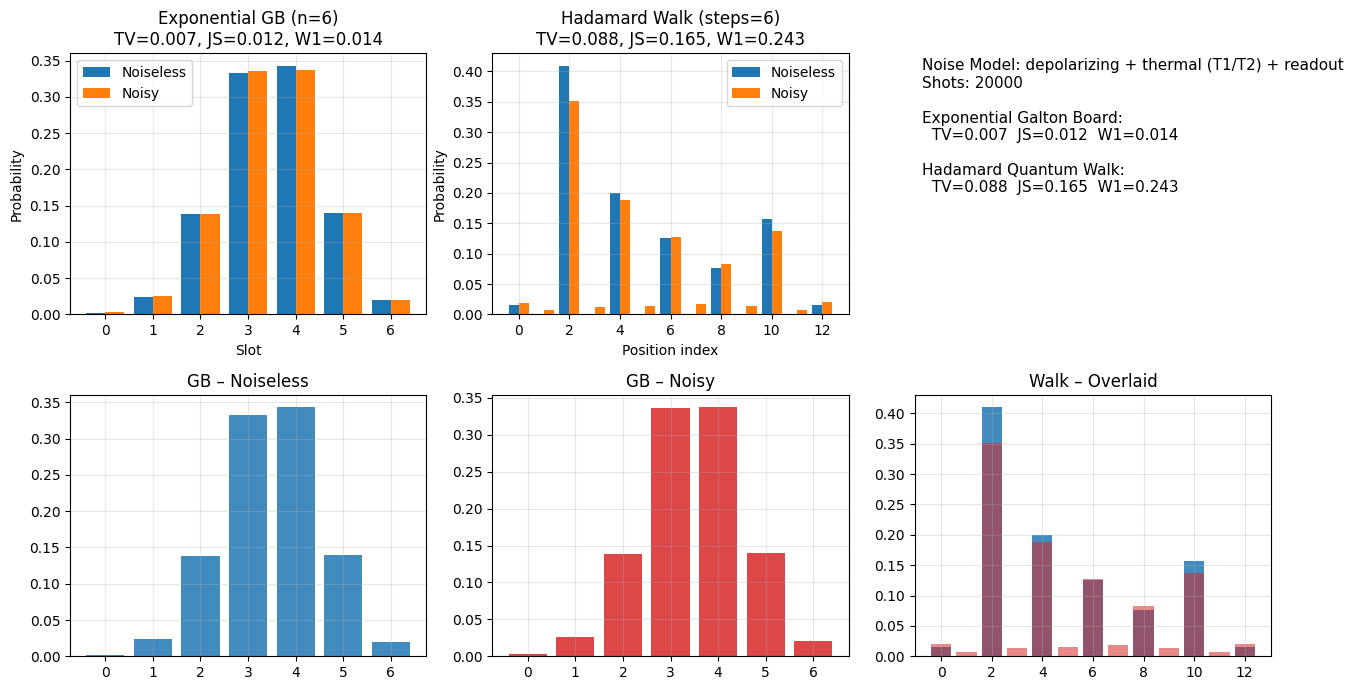

Task 4: Minimal Noise Results
Exponential GB: TV=0.0067, JS=0.0125, W1=0.0141
Hadamard Walk : TV=0.0882,  JS=0.1647,  W1=0.2430


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from scipy.spatial.distance import jensenshannon

def tv(p, q): return 0.5 * np.abs(p - q).sum()
def w1_discrete(p, q):  
    return float(np.abs(np.cumsum(p) - np.cumsum(q)).sum())

def pmf_from_positions(positions, n_slots):
    hist = np.bincount(positions, minlength=n_slots).astype(float)
    return hist / hist.sum() if hist.sum() else hist

def build_simple_noise_model(T1=100e-6, T2=80e-6,
                             p1=5e-4, p2=1e-2, p3=5e-3, p_read=0.02,
                             t1q=35e-9, t2q=500e-9):
    nm = NoiseModel()
    dep1 = depolarizing_error(p1, 1)
    dep2 = depolarizing_error(p2, 2)
    dep3 = depolarizing_error(p3, 3)  # for 3-qubit gates like cswap
    th1  = thermal_relaxation_error(T1, T2, t1q)
    th2  = thermal_relaxation_error(T1, T2, t2q)

    # Single-qubit gates
    nm.add_all_qubit_quantum_error(th1.compose(dep1), ['x','h','rx','reset'])
    # Two-qubit gates
    nm.add_all_qubit_quantum_error(th2.compose(dep2), ['cx'])
    # Three-qubit gates (cswap noise)
    nm.add_all_qubit_quantum_error(dep3, ['cswap'])

    nm.add_all_qubit_readout_error(ReadoutError([[1-p_read, p_read],[p_read, 1-p_read]]))
    return nm

def run_counts(qc, simulator, shots=20000, seed=7):
    tqc = transpile(qc, simulator, optimization_level=1, seed_transpiler=seed)
    return simulator.run(tqc, shots=shots, seed_simulator=seed).result().get_counts()

def logistic_p_list(n, a=-2.0, b=0.7):  # monotone increasing p_ℓ
    l = np.arange(1, n+1, dtype=float)
    return 1/(1+np.exp(-(a + b*l)))

def thetas_from_p_list(p_list):
    return [2*np.arcsin(np.sqrt(p)) for p in p_list]  # p = sin^2(theta/2)

def build_exp_galton_board(n_levels=6, a=-2.0, b=0.7):
    p_list = logistic_p_list(n_levels, a=a, b=b)
    thetas = thetas_from_p_list(p_list)
    try:
        board = QuantumGaltonBoard(n_levels, thetas=thetas)
    except TypeError:
        board = QuantumGaltonBoard(n_levels)
    qc = board.build_circuit()
    return board, qc, n_levels+1  

def build_hadamard_quantum_walk(n_steps=6, n_positions=None):
    if n_positions is None:
        n_positions = 2*n_steps + 1
    coin = QuantumRegister(1, "coin")
    pos  = QuantumRegister(n_positions, "pos")
    creg = ClassicalRegister(n_positions, "c")
    qc = QuantumCircuit(coin, pos, creg)
    center = n_positions//2
    qc.x(pos[center])
    qc.s(coin[0])  

    for _ in range(n_steps):
        qc.h(coin[0])
        for j in range(n_positions-2, -1, -1): 
            qc.cswap(coin[0], pos[j], pos[j+1])
        qc.x(coin[0])
        for j in range(1, n_positions):       
            qc.cswap(coin[0], pos[j], pos[j-1])
        qc.x(coin[0])
        qc.barrier()

    for i in range(n_positions): qc.measure(pos[i], creg[i])
    return qc, n_positions

def one_hot_index(bitstring):
    s = bitstring[::-1]
    return s.index("1") if s.count("1")==1 else None

def noise_demo_task4(seed=7, shots=20000, n_levels=6, n_steps=6):
    noise_model = build_simple_noise_model()
    noiseless = AerSimulator(seed_simulator=seed)
    noisy     = AerSimulator(noise_model=noise_model, seed_simulator=seed)

    fig, axes = plt.subplots(2, 3, figsize=(14, 7))
    plt.subplots_adjust(hspace=0.35)

    gb, qc_gb, nslots_gb = build_exp_galton_board(n_levels=n_levels)
    # run
    c0 = run_counts(qc_gb, noiseless, shots, seed)
    p0 = gb.process_results(c0, shots)
    c1 = run_counts(qc_gb, noisy, shots, seed)
    p1 = gb.process_results(c1, shots)

    pmf0 = pmf_from_positions(p0, nslots_gb)
    pmf1 = pmf_from_positions(p1, nslots_gb)
    js_gb = float(jensenshannon(np.clip(pmf0,1e-12,1), np.clip(pmf1,1e-12,1)))
    tv_gb = tv(pmf0, pmf1)
    w1_gb = w1_discrete(pmf0, pmf1)
    x_gb  = np.arange(nslots_gb)

    ax = axes[0,0]
    ax.bar(x_gb-0.2, pmf0, width=0.4, label="Noiseless")
    ax.bar(x_gb+0.2, pmf1, width=0.4, label="Noisy")
    ax.set_title(f"Exponential GB (n={n_levels})\nTV={tv_gb:.3f}, JS={js_gb:.3f}, W1={w1_gb:.3f}")
    ax.set_xlabel("Slot"); ax.set_ylabel("Probability"); ax.grid(True, alpha=0.3); ax.legend()

    qc_walk, npos = build_hadamard_quantum_walk(n_steps=n_steps)
    # run
    c0w = run_counts(qc_walk, noiseless, shots, seed)
    pos0 = []
    for b,c in c0w.items():
        idx = one_hot_index(b)
        if idx is not None: pos0 += [idx]*(c)
    c1w = run_counts(qc_walk, noisy, shots, seed)
    pos1 = []
    for b,c in c1w.items():
        idx = one_hot_index(b)
        if idx is not None: pos1 += [idx]*(c)

    pmf0w = pmf_from_positions(np.array(pos0), npos)
    pmf1w = pmf_from_positions(np.array(pos1), npos)
    js_w  = float(jensenshannon(np.clip(pmf0w,1e-12,1), np.clip(pmf1w,1e-12,1)))
    tv_w  = tv(pmf0w, pmf1w)
    w1_w  = w1_discrete(pmf0w, pmf1w)
    x_w   = np.arange(npos)

    ax = axes[0,1]
    ax.bar(x_w-0.2, pmf0w, width=0.4, label="Noiseless")
    ax.bar(x_w+0.2, pmf1w, width=0.4, label="Noisy")
    ax.set_title(f"Hadamard Walk (steps={n_steps})\nTV={tv_w:.3f}, JS={js_w:.3f}, W1={w1_w:.3f}")
    ax.set_xlabel("Position index"); ax.set_ylabel("Probability"); ax.grid(True, alpha=0.3); ax.legend()

    axes[0,2].axis("off")
    txt = (
        "Noise Model: depolarizing + thermal (T1/T2) + readout\n"
        f"Shots: {shots}\n\n"
        "Exponential Galton Board:\n"
        f"  TV={tv_gb:.3f}  JS={js_gb:.3f}  W1={w1_gb:.3f}\n\n"
        "Hadamard Quantum Walk:\n"
        f"  TV={tv_w:.3f}  JS={js_w:.3f}  W1={w1_w:.3f}\n"
    )
    axes[0,2].text(0.02, 0.98, txt, va="top", fontsize=11)

    axes[1,0].bar(x_gb, pmf0, alpha=0.85); axes[1,0].set_title("GB – Noiseless"); axes[1,0].grid(True, alpha=0.3)
    axes[1,1].bar(x_gb, pmf1, alpha=0.85, color="tab:red"); axes[1,1].set_title("GB – Noisy"); axes[1,1].grid(True, alpha=0.3)
    axes[1,2].bar(x_w, pmf0w, alpha=0.85); axes[1,2].bar(x_w, pmf1w, alpha=0.55, color="tab:red")
    axes[1,2].set_title("Walk – Overlaid"); axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("Task 4: Minimal Noise Results")
    print(f"Exponential GB: TV={tv_gb:.4f}, JS={js_gb:.4f}, W1={w1_gb:.4f}")
    print(f"Hadamard Walk : TV={tv_w:.4f},  JS={js_w:.4f},  W1={w1_w:.4f}")

noise_demo_task4(n_levels=6, n_steps=6, shots=20000, seed=7)


### Task 4: Noiseless vs Noisy Quantum Galton Board (Real-ish Hardware Model)

This cell runs a **side-by-side comparison** of the Galton board under:
- an **ideal (noiseless)** simulator, and  
- a **noisy** simulator using a **real-ish hardware noise model** (inline depolarizing + readout errors).

**What it does**
1. **Builds the circuit** for `n_levels` (unbiased coin by default).
2. **Creates two simulators**:
   - `sim_ideal` (no noise),  
   - `sim_noisy` with an inline **NoiseModel**:
     - 1-qubit **depolarizing** error (p≈0.001) on common basis gates,  
     - 2-qubit **depolarizing** error (p≈0.01) on `cx`,  
     - **Readout** error (~3% flip rate).
3. **Transpiles the circuit twice** (one per backend). We let `basis_gates`/`coupling_map` be inferred (set to `None`) so each simulator’s constraints are respected.
4. **Runs both circuits** for `shots` (Monte Carlo sampling) and converts raw counts to **slot positions**.
5. **Builds PMFs** (probability mass functions) for ideal vs noisy outputs.
6. **Computes distance metrics** to quantify noise impact:
   - **Total Variation (TV)** : overlap difference of PMFs,  
   - **Jensen–Shannon (JS)** : symmetric, bounded information distance,  
   - **Wasserstein-1 (W1)** : “mass moved” between distributions (CDF-based).
7. **Plots three panels**:
   - Noiseless PMF,  
   - Noisy PMF,  
   - Overlay + metric summary.
8. **Prints means** (ideal vs noisy) and the three distances.

**Why this is useful**
- Quantifies how **hardware-like noise** distorts the ideal binomial-shaped distribution.
- TV/JS/W1 offer **complementary perspectives** (overlap, information difference, and transport).

**Monte Carlo note**
- PMFs are estimated by **repeating the experiment** `shots` times; higher `shots` : smoother, more reliable estimates.


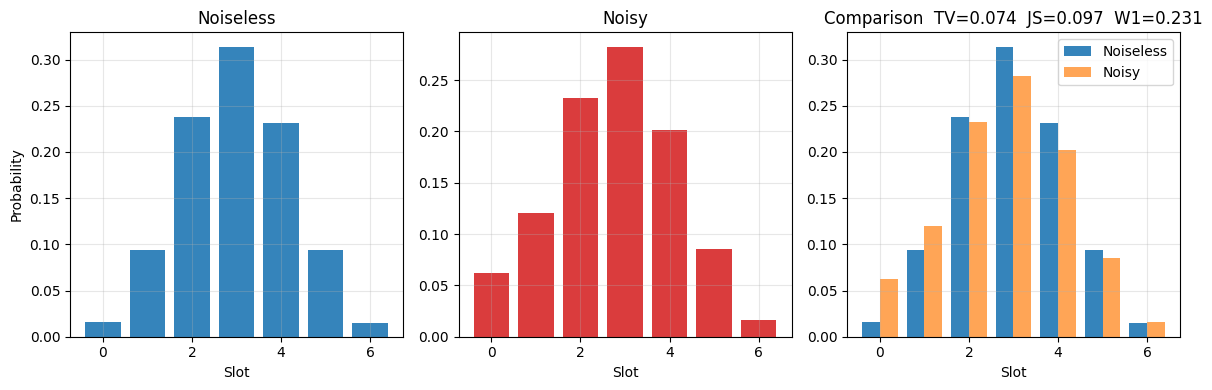

Means: ideal=2.991, noisy=2.762
TV=0.0743  JS=0.0967  W1=0.2312


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from qiskit import transpile
from scipy.spatial.distance import jensenshannon

def run_noise_compare_for_board(n_levels=6, shots=10000, seed=7):
    try:
        qgb = QuantumGaltonBoard(n_levels, thetas=[np.pi/2]*n_levels)
    except TypeError:
        qgb = QuantumGaltonBoard(n_levels)

    qc = qgb.build_circuit()

    noise_model = NoiseModel()
    # 1-qubit depolarizing on common basis gates
    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.001, 1),
                                            ['rx','ry','rz','sx','x','u1','u2','u3'])
    # 2-qubit depolarizing on CX
    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01, 2), ['cx'])
    # readout error (~3% flip)
    noise_model.add_all_qubit_readout_error(ReadoutError([[0.97, 0.03],
                                                          [0.03, 0.97]]))
    basis_gates = None
    coupling_map = None

    sim_ideal = AerSimulator(seed_simulator=seed)
    sim_noisy = AerSimulator(noise_model=noise_model, seed_simulator=seed)

    tqc_ideal = transpile(qc, backend=sim_ideal,
                          basis_gates=basis_gates, coupling_map=coupling_map,
                          optimization_level=1, seed_transpiler=seed)
    tqc_noisy = transpile(qc, backend=sim_noisy,
                          basis_gates=basis_gates, coupling_map=coupling_map,
                          optimization_level=1, seed_transpiler=seed)

    ideal_counts = sim_ideal.run(tqc_ideal, shots=shots, seed_simulator=seed).result().get_counts()
    noisy_counts = sim_noisy.run(tqc_noisy, shots=shots, seed_simulator=seed).result().get_counts()

    pos_ideal = qgb.process_results(ideal_counts, shots)
    pos_noisy = qgb.process_results(noisy_counts, shots)

    def pmf_from_pos(pos, m):
        h = np.bincount(pos, minlength=m+1).astype(float)
        return h/h.sum() if h.sum() else h

    def tv(p,q): return 0.5*np.abs(p-q).sum()
    def w1(p,q): return float(np.abs(np.cumsum(p)-np.cumsum(q)).sum())

    pmf_i = pmf_from_pos(pos_ideal, n_levels)
    pmf_n = pmf_from_pos(pos_noisy, n_levels)
    JS = float(jensenshannon(np.clip(pmf_i,1e-12,1), np.clip(pmf_n,1e-12,1)))
    TV = tv(pmf_i, pmf_n)
    W1 = w1(pmf_i, pmf_n)

    x = np.arange(n_levels+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.bar(x, pmf_i, alpha=0.9); plt.title("Noiseless"); plt.xlabel("Slot"); plt.ylabel("Probability"); plt.grid(True, alpha=0.3)
    plt.subplot(1,3,2); plt.bar(x, pmf_n, alpha=0.9, color='tab:red'); plt.title("Noisy"); plt.xlabel("Slot"); plt.grid(True, alpha=0.3)
    plt.subplot(1,3,3);
    plt.bar(x-0.2, pmf_i, width=0.4, alpha=0.9, label='Noiseless')
    plt.bar(x+0.2, pmf_n, width=0.4, alpha=0.7, label='Noisy')
    plt.title(f"Comparison  TV={TV:.3f}  JS={JS:.3f}  W1={W1:.3f}")
    plt.xlabel("Slot"); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    print(f"Means: ideal={np.mean(pos_ideal):.3f}, noisy={np.mean(pos_noisy):.3f}")
    print(f"TV={TV:.4f}  JS={JS:.4f}  W1={W1:.4f}")

run_noise_compare_for_board(n_levels=6, shots=10000, seed=7)


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon

def pmf_from_positions(pos, n_levels=None):
    pos = np.asarray(pos, dtype=int)
    m = int(np.max(pos)) if n_levels is None else int(n_levels)
    h = np.bincount(pos, minlength=m+1).astype(float)
    return h / h.sum(), np.arange(m+1)

def tv_distance(p, q):
    return 0.5 * np.abs(p - q).sum()

def w1_discrete(p, q):
    return float(np.abs(np.cumsum(p) - np.cumsum(q)).sum())

def compare_and_plot(quant_positions, target_positions, n_levels=None,
                     label_q="Quantum", label_t="Target", title_prefix="Comparison"):
    pmf_q, xq = pmf_from_positions(quant_positions, n_levels)
    pmf_t, xt = pmf_from_positions(target_positions, n_levels)
    m = max(len(pmf_q), len(pmf_t))
    pmf_q = np.pad(pmf_q, (0, m - len(pmf_q)))
    pmf_t = np.pad(pmf_t, (0, m - len(pmf_t)))
    x = np.arange(m)

    # Metrics
    eps = 1e-12
    TV = tv_distance(pmf_q, pmf_t)
    JS = float(jensenshannon(np.clip(pmf_q, eps, 1), np.clip(pmf_t, eps, 1)))
    W1 = w1_discrete(pmf_q, pmf_t)

    # Plot
    plt.figure(figsize=(10, 3.5))
    plt.bar(x - 0.2, pmf_q, width=0.4, alpha=0.9, label=label_q)
    plt.bar(x + 0.2, pmf_t, width=0.4, alpha=0.7, label=label_t)
    plt.title(f"{title_prefix}  TV={TV:.3f}  JS={JS:.3f}  W1={W1:.3f}")
    plt.xlabel("Slot"); plt.ylabel("Probability"); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    return {"TV": TV, "JS": JS, "W1": W1, "x": x, "pmf_q": pmf_q, "pmf_t": pmf_t}


### Task 5 — Minimal, Robust Statistical Distance Analysis (All Distributions)

This cell provides a **robust, uniform way** to compare *any* pair of distributions produced in the notebook (binomial/galton, exponential, quantum walk, or noisy vs noiseless). It discretizes samples to common integer **slots**, aligns supports, computes **PMFs**, and reports **TV / JS / W1** distances with an overlay plot.

---

#### What the helpers do

- **`to_int_slots(a, method="round")`**  
  Discretizes real-valued samples to integer slots using `"round"` (default), `"floor"`, or `"ceil"`. This lets you compare continuous targets (e.g., normal or exponential draws) to discrete quantum outputs on the same grid.

- **`pmf_from_positions(pos, n_levels=None)`**  
  Builds a **probability mass function** over non-negative integer slots. If the data have negatives (e.g., quantum walk displacements), it **shifts** the whole dataset so the support starts at 0. Returns `(pmf, x, shift)`.

- **`tv_distance(p, q)`**  
  Total Variation distance \(\frac12 \sum |p_i-q_i|\); simple and interpretable overlap metric.

- **`w1_discrete(p, q)`**  
  Wasserstein-1 (Earth Mover’s) distance on integer bins via **CDF differences**; sensitive to *where* probability mass moved.

- **`compare_and_plot(quant_positions, target_positions, ...)`**  
  End-to-end comparison:
  1) Discretize both datasets to integer slots (with chosen binning),  
  2) Align non-negative support,  
  3) Compute **TV**, **JS** (Jensen–Shannon), **W1**,  
  4) Plot an **overlay bar chart** with metrics in the title,  
  5) Return the metrics and PMFs.

---

#### What the execution block does

- Assembles `distributions_data` from earlier cells:
  - **Gaussian/Binomial**: quantum Galton (n=12) vs a normal target with same mean/std.  
  - **Exponential**: quantum exponential positions vs exponential target with matched scale.  
  - **Quantum_Walk**: quantum walk vs a normal target with matched mean/std.  
  - *(Optional)* **Noisy_vs_Noiseless** if Task 4 results are present.

- For each entry:
  - Calls `compare_and_plot(...)` to show the overlay and print **TV / JS / W1**.
  - Stores metrics in `metrics_summary` and prints a final **table-style summary**.

---

#### Why this is useful (and where it fits)

- **Task 5 focus**: concise, comparable **distance metrics** across all distributions produced in Tasks 2–4.  
- Works even when targets are **continuous** (through binning) and when supports differ (automatic **shift + padding**).  
- The three metrics together capture **overlap (TV)**, **information distance (JS)**, and **mass displacement (W1)**.

---

#### Notes & Tips

- Use `binning="floor"` or `"ceil"` if you want conservative or upper rounding.  
- Set `n_levels` when you know the exact slot count (e.g., Galton with `n_levels+1` slots); otherwise the function infers from data.  
- Larger sample sizes (shots/trials) give smoother PMFs and more stable metrics.



TASK 5: MINIMAL STATISTICAL DISTANCE ANALYSIS

 GAUSSIAN/BINOMIAL 


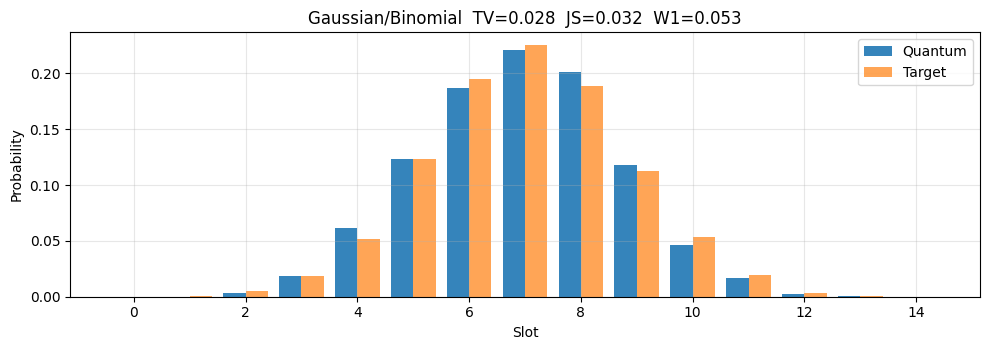


 EXPONENTIAL 


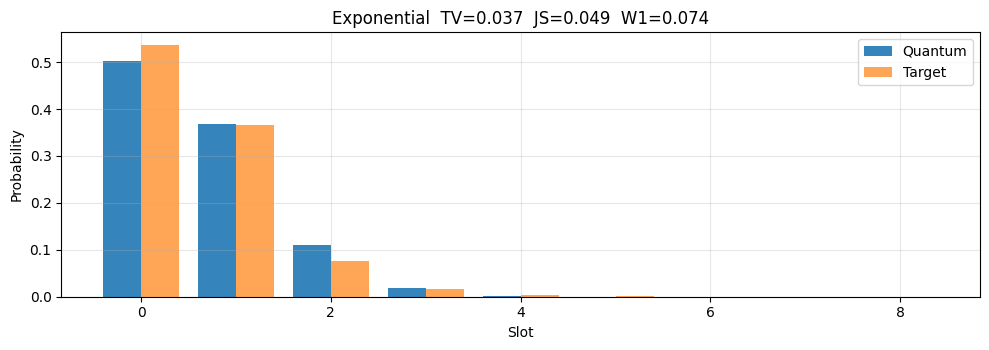


 QUANTUM_WALK 


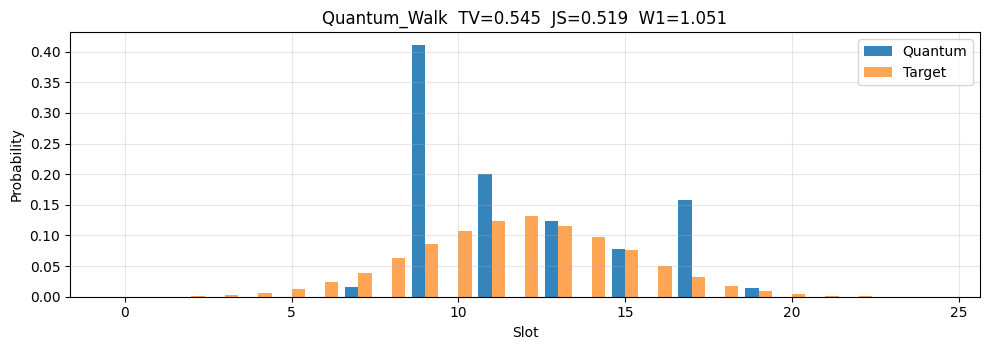


Summary of Metrics:
Gaussian/Binomial     TV=0.028  JS=0.032  W1=0.053
Exponential           TV=0.037  JS=0.049  W1=0.074
Quantum_Walk          TV=0.545  JS=0.519  W1=1.051


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon

def to_int_slots(a, method="round"):
    a = np.asarray(a, dtype=float)
    if method == "floor":
        a = np.floor(a)
    elif method == "ceil":
        a = np.ceil(a)
    else:  # default "round"
        a = np.rint(a)
    return a.astype(int)

def pmf_from_positions(pos, n_levels=None):
    
    pos = np.asarray(pos, dtype=int)
    shift = 0
    if pos.min() < 0:
        shift = -int(pos.min())
        pos = pos + shift
    m = int(np.max(pos)) if n_levels is None else int(n_levels)
    h = np.bincount(pos, minlength=m+1).astype(float)
    pmf = h / h.sum() if h.sum() > 0 else h
    x = np.arange(m+1)
    return pmf, x, shift

def tv_distance(p, q):
    return 0.5 * np.abs(p - q).sum()

def w1_discrete(p, q):
    return float(np.abs(np.cumsum(p) - np.cumsum(q)).sum())

def compare_and_plot(quant_positions, target_positions, n_levels=None,
                     label_q="Quantum", label_t="Target", title_prefix="Comparison",
                     binning="round"):
    
    # Discretize to integer slots
    q_int = to_int_slots(quant_positions, method=binning)
    t_int = to_int_slots(target_positions, method=binning)

    # Align a common shift so both are >= 0 on the same support
    global_min = min(q_int.min() if q_int.size else 0, t_int.min() if t_int.size else 0)
    if global_min < 0:
        q_int = q_int - global_min
        t_int = t_int - global_min

    # PMFs on common support
    pmf_q, xq, _ = pmf_from_positions(q_int, n_levels)
    pmf_t, xt, _ = pmf_from_positions(t_int, n_levels)
    m = max(len(pmf_q), len(pmf_t))
    pmf_q = np.pad(pmf_q, (0, m - len(pmf_q)))
    pmf_t = np.pad(pmf_t, (0, m - len(pmf_t)))
    x = np.arange(m)

    # Metrics
    eps = 1e-12
    TV = tv_distance(pmf_q, pmf_t)
    JS = float(jensenshannon(np.clip(pmf_q, eps, 1), np.clip(pmf_t, eps, 1)))
    W1 = w1_discrete(pmf_q, pmf_t)

    # Plot
    plt.figure(figsize=(10, 3.6))
    plt.bar(x - 0.2, pmf_q, width=0.4, alpha=0.9, label=label_q)
    plt.bar(x + 0.2, pmf_t, width=0.4, alpha=0.7, label=label_t)
    plt.title(f"{title_prefix}  TV={TV:.3f}  JS={JS:.3f}  W1={W1:.3f}")
    plt.xlabel("Slot"); plt.ylabel("Probability"); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    return {"TV": TV, "JS": JS, "W1": W1, "x": x, "pmf_q": pmf_q, "pmf_t": pmf_t}

print("TASK 5: MINIMAL STATISTICAL DISTANCE ANALYSIS")

distributions_data = {
    'Gaussian/Binomial': {
        'quantum': final_results[12]['positions'],
        'target': np.random.normal(
            np.mean(final_results[12]['positions']),
            np.std(final_results[12]['positions']),
            len(final_results[12]['positions'])
        )
    },
    'Exponential': {
        'quantum': exp_positions,
        'target': np.random.exponential(scale=np.mean(exp_positions), size=len(exp_positions))
    },
    'Quantum_Walk': {
        'quantum': walk_positions,
        'target': np.random.normal(
            np.mean(walk_positions),
            np.std(walk_positions),
            len(walk_positions)
        )
    }
}

if 'noise_scaling_results' in globals() and len(noise_scaling_results) > 0:
    best_n = min(noise_scaling_results.keys(), key=lambda k: noise_scaling_results[k]['mean_error'])
    distributions_data['Noisy_vs_Noiseless'] = {
        'quantum': noise_scaling_results[best_n]['noisy_positions'],
        'target': noise_scaling_results[best_n]['noiseless_positions']
    }

metrics_summary = {}
for dist_name, data in distributions_data.items():
    print(f"\n {dist_name.upper()} ")
    metrics = compare_and_plot(
        data['quantum'],
        data['target'],
        n_levels=None,           # or set to known n_levels for that experiment
        label_q="Quantum",
        label_t="Target",
        title_prefix=dist_name,
        binning="round"          # "round" | "floor" | "ceil"
    )
    metrics_summary[dist_name] = metrics

print("\nSummary of Metrics:")
for name, m in metrics_summary.items():
    print(f"{name:20}  TV={m['TV']:.3f}  JS={m['JS']:.3f}  W1={m['W1']:.3f}")
